In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import pandas as pd
import time
import copy
import pickle
import warnings
import matplotlib.cm as cm
import seaborn as sns
from numpy.linalg import svd, matrix_rank, qr
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import norm

from netdyn import *

In [2]:
def initialize_adjacency_matrix(matrix, seed=None):
    """
    1 to [0.5, 1.5], 0 remaining
    """
    if seed is not None:
        np.random.seed(seed)
        
    matrix = np.array(matrix, dtype=float)
    mask = (matrix == 1)
    matrix[mask] = np.random.uniform(0.5, 1.5, size=mask.sum())
    return matrix

<font color = black size = 5>Reconstruct surrogate network and simulate dynamics</font>

In [3]:
def compute_rmse(X_true, X_pred):
    """
    Compute RMSE between predicted and true trajectories.
    """
    min_len = min(len(X_true), len(X_pred))
    err = X_true[:min_len] - X_pred[:min_len]
    return np.sqrt(np.mean(err**2))

In [4]:
def reconstruct_network_generic(X, model, val_ratio=0.2, n_alphas=20, threshold=0.01):
    """
    通用的网络重构函数 (基于 SI Appendix Algorithm 1)。

    参数:
    -------
    X : np.array, shape (T, N)
        节点状态的时间序列。
    model : NetworkDynamics object
        实例化的动力学模型对象 (如 LVDynamics, SISDynamics 等)。
        *必须已经初始化了正确的参数 (alpha, theta, 等)*。
    val_ratio : float
        验证集比例。
    n_alphas : int
        交叉验证搜索的超参数数量。
    threshold : float
        硬阈值。

    返回:
    -------
    A_hat : np.array, shape (N, N)
        重构的邻接矩阵。
    """
    
    T, N = X.shape
    dt = model.dt
    
    if T <= 1:
        raise ValueError("Time series X must have at least 2 steps.")

    # 1. 准备数据切片
    X_t = X[:-1]      # t
    X_tp1 = X[1:]     # t+1
    t_len = len(X_t)

    # 2. 计算导数近似 (左边项的一部分)
    deriv_approx = (X_tp1 - X_t) / dt

    # 3. 利用模型接口获取 f(x) 和 Phi(x)
    #    模型内部会自动处理 LV, SIS, MM 等不同方程的差异
    print(f"Eigenmatrix (Model: {model.__class__.__name__})...")
    
    # 计算自身动力学 f(x(t))
    # result shape: (T-1, N)
    f_term = model.f(X_t)
    
    # 目标 Y = dx/dt - f(x)
    Y_target = deriv_approx - f_term

    # 计算相互作用特征 g(x_i, x_j)
    # result shape: (T-1, N, N)
    Phi_features = model.get_interaction_matrix(X_t)

    # 4. 划分训练/验证集
    n_train = int(t_len * (1 - val_ratio))
    
    Y_train, Y_val = Y_target[:n_train], Y_target[n_train:]
    Phi_train, Phi_val = Phi_features[:n_train], Phi_features[n_train:]

    A_hat = np.zeros((N, N))
    print("Lasso regression for each node...")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        for i in range(N):
            # 提取节点 i 的数据
            y_train_i = Y_train[:, i]       # (n_train,)
            Phi_train_i = Phi_train[:, i, :]  # (n_train, N)
            
            y_val_i = Y_val[:, i]
            Phi_val_i = Phi_val[:, i, :]
            
            # 启发式确定 rho_max (alpha_max)
            # 避免全零的除法安全处理
            dot_prod = Phi_train_i.T @ y_train_i
            rho_max = np.max(np.abs(dot_prod)) / n_train if n_train > 0 else 1.0
            if rho_max < 1e-9: rho_max = 1e-3
            
            rho_min = 1e-4 * rho_max
            alphas = np.logspace(np.log10(rho_min), np.log10(rho_max), n_alphas)
            
            best_mse = np.inf
            best_alpha = alphas[0]
            
            # Cross-Validation loop
            for alpha_val in alphas:
                # 关键：保持 positive=True 以符合物理约束
                lasso = Lasso(alpha=alpha_val, fit_intercept=False, positive=True, 
                              max_iter=2000, tol=1e-4)
                lasso.fit(Phi_train_i, y_train_i)
                
                # Thresholding
                coef = lasso.coef_.copy()
                coef[np.abs(coef) < threshold] = 0
                
                if np.sum(np.abs(coef)) == 0:
                    # 避免全零预测的空值错误，用 0 预测的 MSE
                    mse = np.mean(y_val_i**2)
                else:
                    y_pred = Phi_val_i @ coef
                    mse = mean_squared_error(y_val_i, y_pred)
                
                if mse < best_mse:
                    best_mse = mse
                    best_alpha = alpha_val

            # Final Fit on full dataset
            y_target_i_full = Y_target[:, i]
            Phi_features_i_full = Phi_features[:, i, :]
            
            lasso_final = Lasso(alpha=best_alpha, fit_intercept=False, positive=True,
                                max_iter=10000, tol=1e-4)
            lasso_final.fit(Phi_features_i_full, y_target_i_full)
            
            final_coef = lasso_final.coef_
            final_coef[np.abs(final_coef) < threshold] = 0
            
            A_hat[i, :] = final_coef

    return A_hat

In [5]:
def evaluate_prediction_accuracy(X_true, X_pred, t_split):
    # evaluate t > t_obs 
    X_true_future = X_true[t_split:]
    X_pred_future = X_pred[t_split:]
    
    if len(X_true_future) == 0:
        print("Error：No prediction data in (t_split >= Total)")
        return None, None

    # 2. 计算绝对误差矩阵 |x - x_hat|
    abs_error_matrix = np.abs(X_true_future - X_pred_future)
    
    # 3. 计算指标
    # (a) Time depend MAE (Eq. 30 in SI)
    epsilon_t = np.mean(abs_error_matrix, axis=1)
    
    # (b) Global MAE (epsilon_bar in SI) 
    epsilon_bar = np.mean(abs_error_matrix)
    
    return epsilon_t, epsilon_bar

In [10]:
# # 读取并修复XML文件
# with open('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock.xml', 'r', encoding='utf-8') as f:
#     content = f.read()

# # 替换非标准类型
# content = content.replace('attr.type="vector_float"', 'attr.type="string"')
# content = content.replace('attr.type="vector_string"', 'attr.type="string"')

# # 保存修复后的文件
# with open('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock_fixed.xml', 'w', encoding='utf-8') as f:
#     f.write(content)

# print("XML文件已修复，保存为 foodweb_little_rock_fixed.xml")

# G = nx.read_graphml('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock_fixed.xml')
# A_lrl = nx.to_numpy_array(G)

In [120]:
# with open('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock_lake.pkl', 'wb') as f:
#     pickle.dump(A_lrl, f)

with open('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock_lake.pkl', 'rb') as f:
    A_lrl = pickle.load(f)

In [136]:
N = A_lrl.shape[0]
seed = 42
np.random.seed(42)
alpha_vals = np.random.uniform(0.5, 1.5, N)
theta_vals = np.random.uniform(0.5, 1.5, N)
initial_state_vals = np.random.uniform(0, 1.0, N)

A_true = copy.deepcopy(A_lrl)

In [122]:
# 2. 定义动力学模型 (只需在这里修改参数)
'''
LVDynamics(N, alpha, theta, dt=0.1)
MPDynamics(N, alpha, theta, dt=0.1)
MMDynamics(N, h, dt=0.1)
SISDynamics(N, beta, delta, dt=0.1)
KuramotoDynamics(N, omega, dt=0.05)
WCDynamics(N, tau, mu, dt=0.1)
'''
model = LVDynamics(N, alpha=alpha_vals, theta=theta_vals, dt=0.1)

In [123]:
T_total_steps = 100
T_train_steps = 20

In [124]:
print(f"Running Ground Truth simulation on A_true (Total steps: {T_total_steps})...")
X_obs = model.simulate(A_true, T_steps=T_total_steps, init_state=initial_state_vals, seed=42)
print("A_true simulation finish")

Running Ground Truth simulation on A_true (Total steps: 100)...
A_true simulation finish


In [125]:
X_train = X_obs[:T_train_steps] 
x0_pred = X_obs[T_train_steps]   # 这是 t=50 时刻的状态
X_future_true = X_obs[T_train_steps:] 

print(f"Reconstructing surrogate network using first {T_train_steps} steps...")
A_hat = reconstruct_network_generic(X_train, model, threshold=0.01)
print(f"Reconstructing surrogate network finish")

Reconstructing surrogate network using first 20 steps...
Eigenmatrix (Model: LVDynamics)...
Lasso regression for each node...
Reconstructing surrogate network finish


In [126]:
print("Predicting future dynamics on A_hat...")
T_pred_steps = T_total_steps - T_train_steps
X_future_pred = model.simulate(A_hat, T_steps=T_pred_steps, init_state=x0_pred)
X_full_pred = np.vstack([X_train, X_future_pred])
print("A_hat simulation finish")

Predicting future dynamics on A_hat...
A_hat simulation finish


In [118]:
def plot_network_and_dynamics_comparison(A_true, A_compare, 
                                         X_true, X_compare, 
                                         T_train_steps, 
                                         num_plot_nodes=20, 
                                         scatter_interval=3,
                                         name_compare="Surrogate"):
    """
    对比两个网络及其动力学轨迹的通用绘图函数。
    包含：
    1. 两个网络的邻接矩阵热图 (Top Row)。
    2. 两个网络的动力学轨迹对比 (Bottom Row, Line vs Scatter)。

    参数:
    -------
    A_true        : np.array, 真实网络矩阵 (Ground Truth)
    A_compare     : np.array, 待比较的网络矩阵 (如 A_hat, A_rdpg 等)
    X_true        : np.array, 真实动力学轨迹
    X_compare     : np.array, 待比较的动力学轨迹
    T_train_steps : int, 训练/预测的分界时间步
    num_plot_nodes: int, 绘制多少个节点 (均匀采样)
    scatter_interval: int, 散点绘制的间隔 (防止点太密)
    name_compare  : str, 待比较对象的名称 (用于图标题和图例，如 "A_hat", "RDPG")
    """
    
    # 1. 基础数据准备
    N = A_true.shape[0]
    T_total_steps = X_true.shape[0]
    time_steps = np.arange(T_total_steps)

    # 2. 确定要绘制的节点
    if num_plot_nodes > N: 
        num_plot_nodes = N
    # 均匀选择节点索引
    nodes_to_plot = np.linspace(0, N-1, num_plot_nodes, dtype=int)
    
    # 3. 生成颜色映射 (沿用你喜欢的 tab10)
    # 如果节点数少于10，直接取色；多于10则插值
    if num_plot_nodes <= 10:
        colors = [plt.cm.tab10(i) for i in range(num_plot_nodes)]
    else:
        colors = plt.cm.tab10(np.linspace(0, 1, num_plot_nodes))

    # ==========================================
    # 开始绘图
    # ==========================================
    fig = plt.figure(figsize=(14, 10))
    grid = plt.GridSpec(2, 2, height_ratios=[1, 1.5])

    # --- 图 1: 网络拓扑对比 (Top Left: True) ---
    ax1 = fig.add_subplot(grid[0, 0])
    cax1 = ax1.imshow(A_true, cmap='Blues', interpolation='nearest')
    ax1.set_title("True Network ($A_{true}$)")
    fig.colorbar(cax1, ax=ax1)

    # --- 图 2: 网络拓扑对比 (Top Right: Compare) ---
    ax2 = fig.add_subplot(grid[0, 1])
    cax2 = ax2.imshow(A_compare, cmap='Reds', interpolation='nearest')
    ax2.set_title(f"Comparison Network ({name_compare})")
    fig.colorbar(cax2, ax=ax2)

    # 计算拓扑相关性
    flatten_true = A_true.flatten()
    flatten_compare = A_compare.flatten()
    corr = np.corrcoef(flatten_true, flatten_compare)[0, 1]
    ax2.set_xlabel(f"Topology Correlation: {corr:.4f}")

    # --- 图 3: 动力学轨迹对比 (Bottom: Dynamics) ---
    ax3 = fig.add_subplot(grid[1, :])

    for idx, node_idx in enumerate(nodes_to_plot):
        color = colors[idx]
        
        # A. 绘制真实轨迹 (实线)
        ax3.plot(time_steps, X_true[:, node_idx], 
                 color=color, linestyle='-', linewidth=2, alpha=0.6,
                 label=f'Node {node_idx} (True)' if idx == 0 else None)
        
        # B. 绘制 对比轨迹 (散点 - 空心圆)
        sparse_indices = np.arange(0, T_total_steps, scatter_interval)
        
        # 确保索引不越界 (防止 X_compare 长度不够)
        sparse_indices = sparse_indices[sparse_indices < len(X_compare)]
        
        ax3.scatter(time_steps[sparse_indices], X_compare[sparse_indices, node_idx], 
                    edgecolors=color,    # 边框颜色
                    facecolors='none',   # 内部透明
                    marker='o',          # 圆圈
                    s=40,                # 大小
                    linewidth=1.5,       # 线宽
                    label=f'Node {node_idx} ({name_compare})' if idx == 0 else None)

    # 添加训练/预测分界线
    ax3.axvline(x=T_train_steps, color='k', linestyle=':', linewidth=2, alpha=0.8)
    
    # 动态调整标题和标签
    ax3.set_title(f"Dynamics: True (Line) vs {name_compare} (Scatter)\n(Showing {num_plot_nodes} nodes)", fontsize=14)
    ax3.set_xlabel("Time Steps", fontsize=12)
    ax3.set_ylabel("State $x_i(t)$", fontsize=12)

    # --- 优化图例 ---
    custom_lines = [
        Line2D([0], [0], color='gray', lw=2, linestyle='-'),
        Line2D([0], [0], color='gray', marker='o', linestyle='None', 
               markerfacecolor='none', markeredgewidth=1.5)
    ]
    ax3.legend(custom_lines, 
               ['True Dynamics (Ground Truth)', f'{name_compare} Simulation'], 
               loc='upper left', fontsize=10)

    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

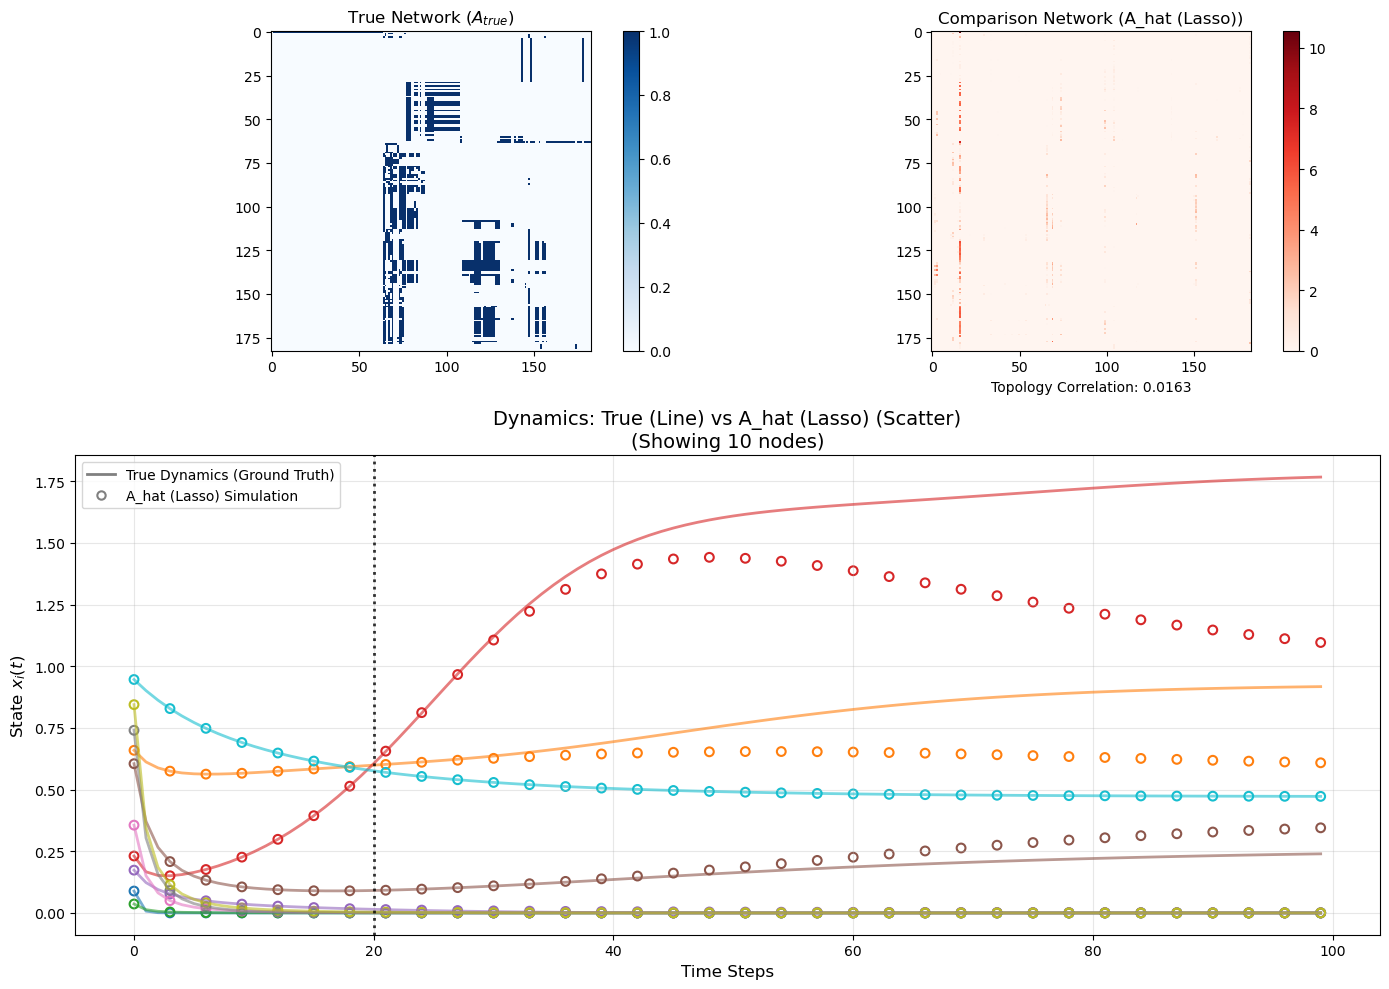

In [127]:
plot_network_and_dynamics_comparison(
    A_true=A_true, 
    A_compare=A_hat, 
    X_true=X_obs, 
    X_compare=X_full_pred, 
    T_train_steps=T_train_steps,
    num_plot_nodes=10, 
    name_compare="A_hat (Lasso)"
)

Total steps in prediction: 80
Global everage (MAE, epsilon_bar): 0.049962


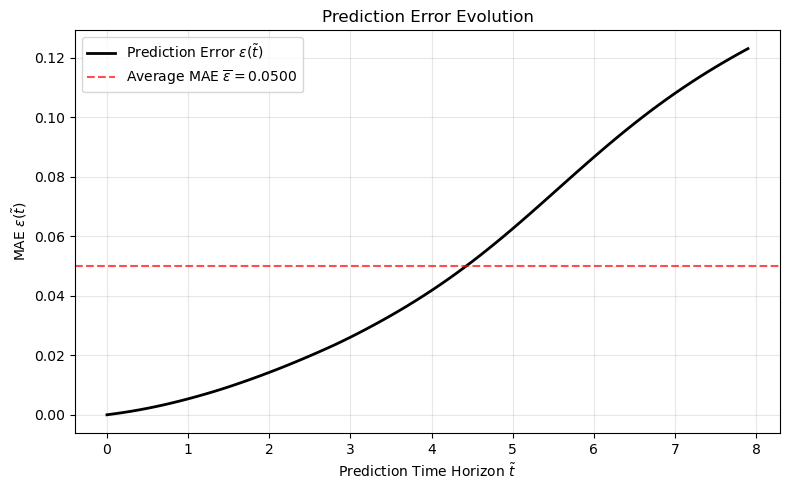

In [17]:
epsilon_t, epsilon_bar = evaluate_prediction_accuracy(X_obs, X_full_pred, T_train_steps)

print(f"Total steps in prediction: {len(epsilon_t)}")
print(f"Global everage (MAE, epsilon_bar): {epsilon_bar:.6f}")

# ==========================================
# 绘制误差演化图 (对应 SI Fig. S10)
# ==========================================
plt.figure(figsize=(8, 5))

# 生成相对时间轴 (Prediction Time Horizon)
dt = 0.1
time_horizon = np.arange(len(epsilon_t)) * dt  # 假设 dt 已知

plt.plot(time_horizon, epsilon_t, 'k-', lw=2, label=r'Prediction Error $\epsilon(\tilde{t})$')

# 标记全局平均线
plt.axhline(y=epsilon_bar, color='r', linestyle='--', alpha=0.7, 
            label=f'Average MAE $\overline{{\epsilon}}={epsilon_bar:.4f}$')

plt.xlabel(r"Prediction Time Horizon $\tilde{t}$")
plt.ylabel(r"MAE $\epsilon(\tilde{t})$")
plt.title("Prediction Error Evolution")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<font color = black size = 5>Compare surrogate network & true network</font>

In [18]:
def get_comprehensive_metrics(A, name="Network", threshold=1e-5):
    """
    SVD, ranks, topology(degree distribution)
    """
    # 1. SVD 分解
    U, S, Vt = svd(A, full_matrices=False)
    
    # 2. 计算有效秩
    sigma_1 = S[0] if S[0] > 1e-12 else 1.0
    srank = np.sum(S**2) / (sigma_1**2)
    nrank = np.sum(S) / sigma_1
    p = S / np.sum(S)
    p = p[p > 1e-12]
    erank = np.exp(-np.sum(p * np.log(p)))
    
    # 3. 二值化矩阵，统计每个节点的度 (Row Sum)
    binary_A = (np.abs(A) > threshold).astype(int)
    in_degrees = np.sum(binary_A, axis=1) 
    
    return {
        "name": name,
        "U": U, "S": S, "Vt": Vt,
        "ranks": {
            "Stable": srank, 
            "Nuclear": nrank, 
            "Entropy": erank
        },
        # 这里是新增的键，之前报错就是因为缺这个
        "topology": {
            "in_degrees": in_degrees,
            "num_edges": np.sum(binary_A),
            "binary_matrix": binary_A
        },
        "shape": A.shape
    }

In [19]:
def plot_multi_matrix_comparison(metrics_list):
    """
    绘制多矩阵对比图 (1 True vs N Surrogates)。
    颜色优化版：True 使用深蓝色，Surrogates 使用鲜明的对比色。
    """
    # 1. 基础设置
    n_matrices = len(metrics_list)
    if n_matrices < 2:
        print("错误：列表至少需要包含 2 个矩阵 (1 True + 1 Hat)")
        return

    mt = metrics_list[0]      # Ground Truth
    m_hats = metrics_list[1:] # Surrogates List
    
    # ================= 颜色修改区域 =================
    # 1. True Network: 使用 'navy' (深海军蓝) 代替原来的 'black'
    #    也可以尝试: '#1f77b4' (标准蓝), 'crimson' (深红), 'darkslategray' (深灰青)
    color_true = 'navy' 
    
    # 2. Surrogates: 使用 tab10 色盘，但跳过蓝色 (index 0)
    #    这样 Hat1 会是 橙色, Hat2 是 绿色, Hat3 是 红色...
    colors = [color_true] + [cm.tab10(i + 1) for i in range(len(m_hats))]
    # ==============================================
    
    # 创建画布
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    # fig.suptitle(f"Multi-Network Comparison (N={n_matrices})", fontsize=18, y=0.96)
    
    # ----------------------------------------------------
    # 图 1: 有效秩对比 (Grouped Bar Chart)
    # ----------------------------------------------------
    ax1 = axes[0, 0]
    rank_keys = ['Stable', 'Nuclear', 'Entropy']
    
    total_width = 0.8
    bar_width = total_width / n_matrices
    x_base = np.arange(len(rank_keys))
    
    # 绘制 True
    vals_t = [mt['ranks'][k] for k in rank_keys]
    x_offset = x_base - (total_width - bar_width)/2
    # alpha 改为 0.9 让基准色更实
    ax1.bar(x_offset, vals_t, width=bar_width, label=mt['name'], color=colors[0], alpha=0.9)
    
    # 绘制 Hats
    for idx, mh in enumerate(m_hats):
        vals_h = [mh['ranks'][k] for k in rank_keys]
        curr_x = x_offset + (idx + 1) * bar_width
        ax1.bar(curr_x, vals_h, width=bar_width, label=mh['name'], color=colors[idx+1], alpha=0.7)
        
        if idx == 0: 
            for i, v in enumerate(vals_h):
                ax1.text(curr_x[i], v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

    ax1.set_xticks(x_base)
    ax1.set_xticklabels([f"{k} Rank" for k in rank_keys])
    ax1.set_title("1. Effective Ranks Comparison")
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(axis='y', linestyle='--', alpha=0.3)

    # ----------------------------------------------------
    # 图 2: 奇异值谱 (Multi-Line Plot)
    # ----------------------------------------------------
    ax2 = axes[0, 1]
    
    # Plot True
    ax2.plot(mt['S'], 'o-', label=mt['name'], color=colors[0], linewidth=2.5, markersize=5, alpha=0.9)
    
    # Plot Hats
    for idx, mh in enumerate(m_hats):
        ax2.plot(mh['S'], '.--', label=mh['name'], color=colors[idx+1], linewidth=1.5, markersize=4, alpha=0.7)
        
    ax2.set_yscale('log')
    ax2.set_title("2. Singular Value Spectrum (Log Scale)")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Singular Value")
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # ----------------------------------------------------
    # 图 3: 节点嵌入 (U Scatter)
    # ----------------------------------------------------
    ax3 = axes[1, 0]
    
    # Plot True
    ax3.scatter(mt['U'][:, 0], mt['U'][:, 1], c=colors[0], label=mt['name'], s=60, alpha=0.7, edgecolors='w')
    
    # Plot Hats
    for idx, mh in enumerate(m_hats):
        U_aligned, _ = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        
        ax3.scatter(U_aligned[:, 0], U_aligned[:, 1], 
                    color=colors[idx+1], label=mh['name'], 
                    marker='+', s=70, alpha=0.8)
        
        if idx == 0:
            for i in range(len(mt['U'])):
                ax3.plot([mt['U'][i, 0], U_aligned[i, 0]], 
                         [mt['U'][i, 1], U_aligned[i, 1]], 
                         color='gray', alpha=0.15, linewidth=0.8)

    ax3.set_title("3. Node Embedding (Top-2 Eigenmodes)")
    ax3.set_xlabel("Dimension 1")
    ax3.set_ylabel("Dimension 2")
    ax3.grid(True, alpha=0.3)

    # ----------------------------------------------------
    # 图 4: 模式堆叠热图 (Stacked Heatmap)
    # ----------------------------------------------------
    ax4 = axes[1, 1]
    
    k = 3 
    if mt['Vt'].shape[0] < k: k = mt['Vt'].shape[0]
    
    stack_list = []
    ytick_labels = []
    current_y = 0
    ytick_locs = []
    
    # True
    stack_list.append(mt['Vt'][:k, :])
    stack_list.append(np.full((1, mt['Vt'].shape[1]), np.nan))
    
    ytick_locs.extend(range(current_y, current_y + k))
    ytick_labels.extend([f"T-{i+1}" for i in range(k)])
    current_y += k + 1
    
    # Hats
    for idx, mh in enumerate(m_hats):
        _, Vt_aligned = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        
        stack_list.append(Vt_aligned[:k, :])
        stack_list.append(np.full((1, mt['Vt'].shape[1]), np.nan))
        
        ytick_locs.extend(range(current_y, current_y + k))
        # 简化标签：H1-1 代表 第1个Hat的第1个向量
        ytick_labels.extend([f"H{idx+1}-{i+1}" for i in range(k)])
        current_y += k + 1
        
    full_matrix = np.vstack(stack_list)
    
    cax = ax4.imshow(full_matrix, aspect='auto', cmap='RdBu_r', vmin=-0.3, vmax=0.3)
    ax4.set_yticks(ytick_locs)
    ax4.set_yticklabels(ytick_labels, fontsize=8)
    ax4.set_title(f"4. Interaction Modes Comparison (Top {k})")
    ax4.set_xlabel("Node Index")
    plt.colorbar(cax, ax=ax4)

    plt.tight_layout()
    plt.show()

In [20]:
# Rotate 2 networks
def align_svd_signs(U_ref, Vt_ref, U_target, Vt_target):
    U_new = U_target.copy()
    Vt_new = Vt_target.copy()
    k = min(U_ref.shape[1], U_target.shape[1])
    for i in range(k):
        if np.dot(U_ref[:, i], U_target[:, i]) < 0:
            U_new[:, i] *= -1
            Vt_new[i, :] *= -1
    return U_new, Vt_new

In [21]:
all_metrics = []

# Computing Ground Truth
print(f"Computing true network (N={N})...")
metrics_true = get_comprehensive_metrics(A_true, name="True Network")
all_metrics.append(metrics_true)

# Computing Surrogate
print(f"Computing surrogate network...")
metrics_hat = get_comprehensive_metrics(A_hat, name="Surrogate (Lasso)")
all_metrics.append(metrics_hat)

# ex for if there are a sets of surrogate networks：
# A_hat_variants = [A_hat_rho1, A_hat_rho2, ...]
# names = ["Lasso (rho=0.1)", "Lasso (rho=0.01)"]
# for A_h, name in zip(A_hat_variants, names):
#     m = get_comprehensive_metrics(A_h, name=name)
#     all_metrics.append(m)

print("-" * 30)
print(f"Computing finish! {len(all_metrics)} sets data saved to 'all_metrics'")
print("Data structure keys:", all_metrics[0].keys())

Computing true network (N=183)...
Computing surrogate network...
------------------------------
Computing finish! 2 sets data saved to 'all_metrics'
Data structure keys: dict_keys(['name', 'U', 'S', 'Vt', 'ranks', 'topology', 'shape'])


In [24]:
metrics_true['U']

array([[ 9.45584391e-18, -1.05791136e-18,  4.24274815e-18, ...,
         0.00000000e+00,  2.15926100e-16,  0.00000000e+00],
       [ 3.19488960e-02, -3.57441391e-03,  1.43351689e-02, ...,
         0.00000000e+00,  7.29559474e-01,  0.00000000e+00],
       [ 1.10174912e-02, -7.69781840e-03, -1.71780843e-02, ...,
         6.37816341e-02, -7.25576736e-02,  1.86306585e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  6.70897485e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  6.70897485e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

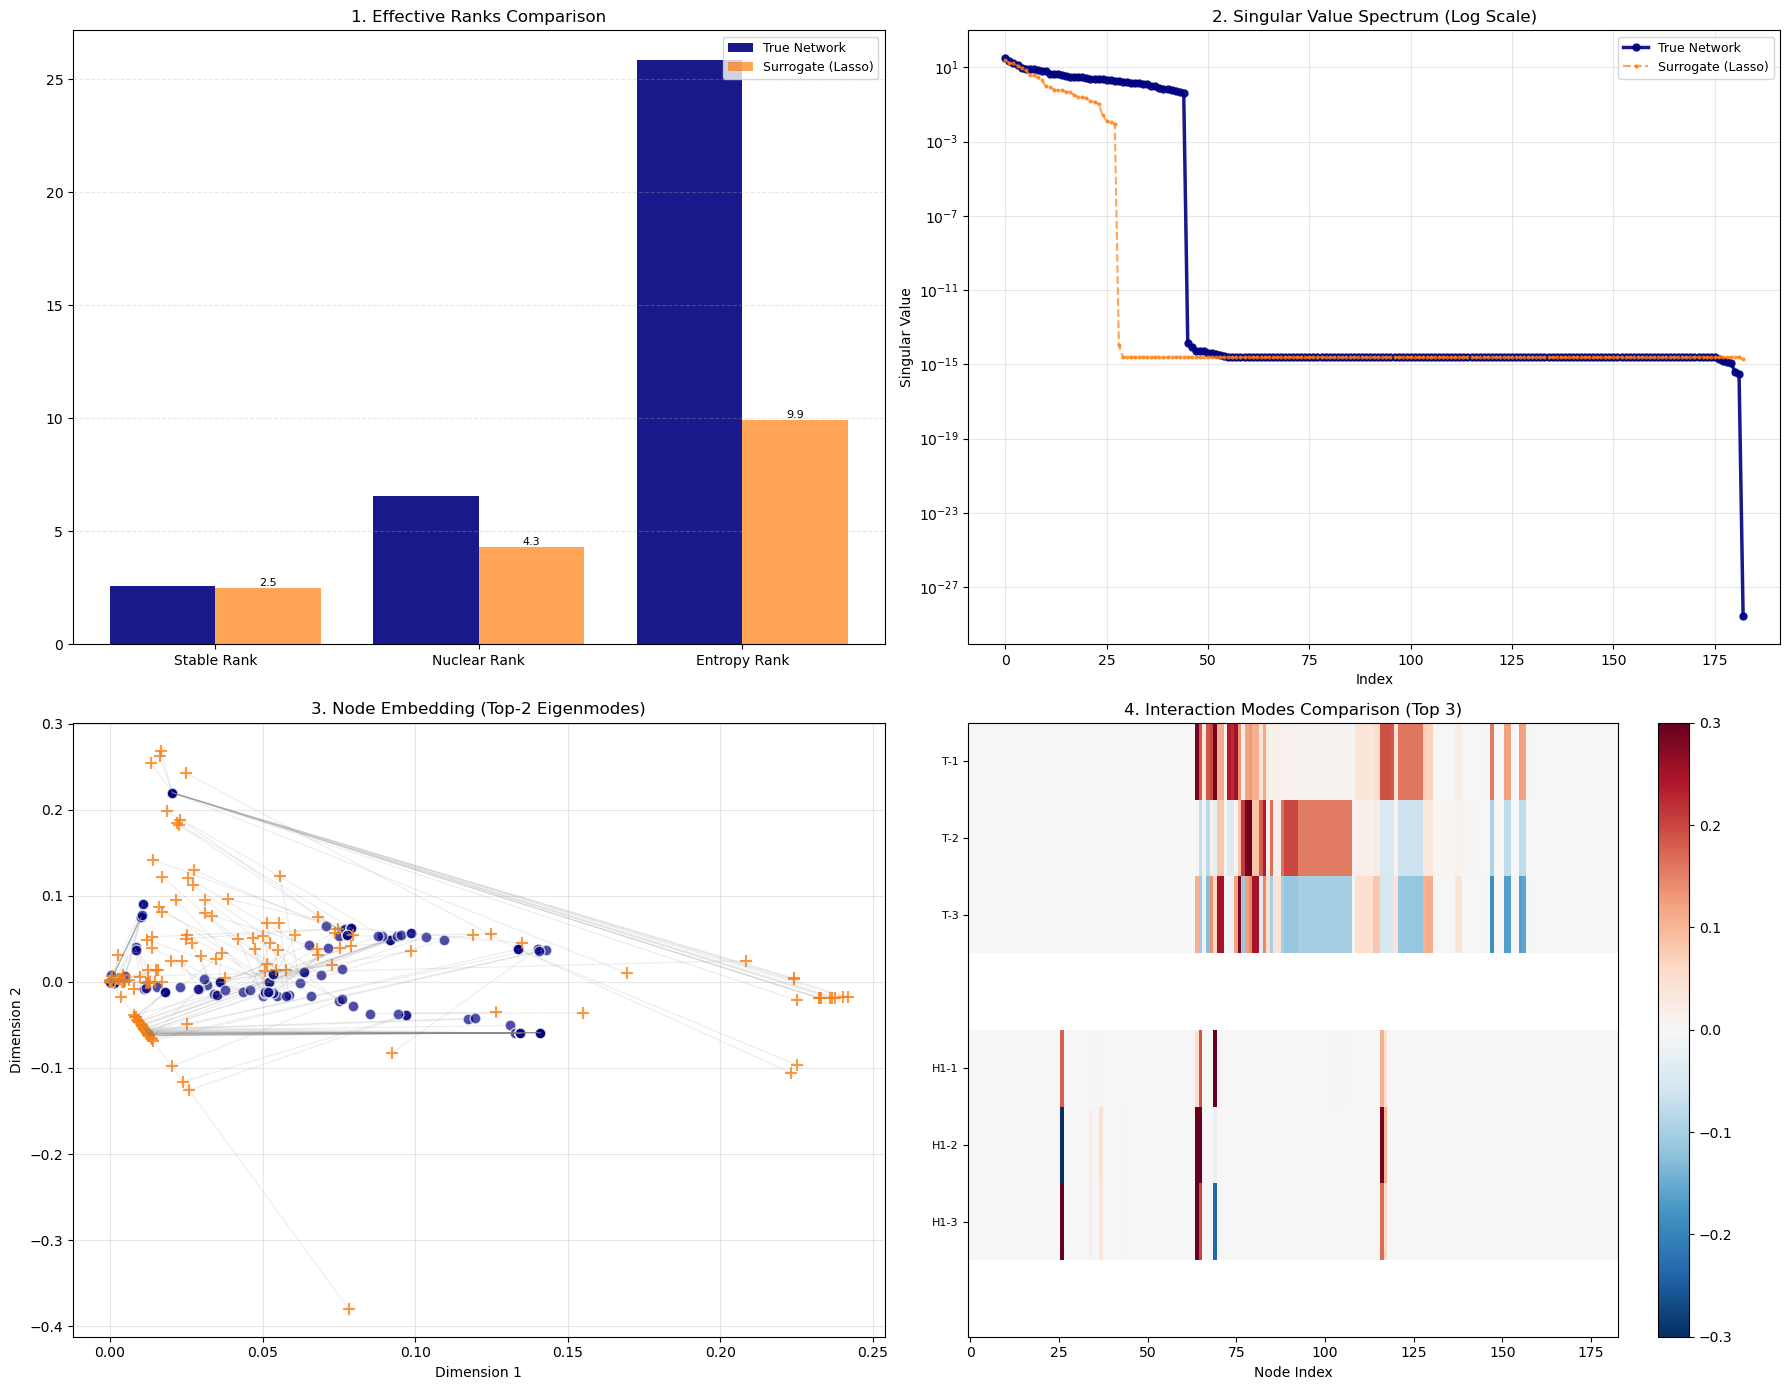

In [59]:
plot_multi_matrix_comparison(all_metrics)

In [64]:
# -----------------------------------------------------------
# 辅助函数：符号对齐 (保持不变，但至关重要)
# -----------------------------------------------------------
def align_svd_signs(U_ref, Vt_ref, U_target, Vt_target):
    """
    校正 SVD 的符号模糊性。
    """
    U_new = U_target.copy()
    Vt_new = Vt_target.copy()
    
    k = min(U_ref.shape[1], U_target.shape[1])
    
    for i in range(k):
        # 检查 U 的每一列方向
        if np.dot(U_ref[:, i], U_target[:, i]) < 0:
            U_new[:, i] *= -1
            Vt_new[i, :] *= -1
            
    return U_new, Vt_new

# -----------------------------------------------------------
# 主函数：6-Panel 均衡对比 (S, U, V 全覆盖)
# -----------------------------------------------------------
def plot_balanced_svd_comparison(metrics_list, top_k_modes=10):
    """
    绘制 SVD 全维度对比图 (2x3 Layout)。
    修改点：图3 改为 U 向量相似度。
    """
    n_matrices = len(metrics_list)
    if n_matrices < 2:
        print("Error: Need at least 2 matrices.")
        return

    mt = metrics_list[0]      # Ground Truth
    m_hats = metrics_list[1:] # Surrogates
    
    # 颜色策略
    color_true = 'navy'
    colors = [color_true] + [cm.tab10(i + 1) for i in range(len(m_hats))]
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f"SVD Analysis: S (Energy), U (Nodes), V (Patterns)", fontsize=18, y=0.96)
    
    # ====================================================
    # 图 1: 有效秩 (Effective Ranks) - 保持不变
    # ====================================================
    ax1 = axes[0, 0]
    rank_keys = ['Stable', 'Nuclear', 'Entropy']
    total_width = 0.8
    bar_width = total_width / n_matrices
    x_base = np.arange(len(rank_keys))
    
    ax1.bar(x_base - (total_width-bar_width)/2, [mt['ranks'][k] for k in rank_keys], 
            width=bar_width, label=mt['name'], color=colors[0], alpha=0.9)
    
    for idx, mh in enumerate(m_hats):
        curr_x = x_base - (total_width-bar_width)/2 + (idx+1)*bar_width
        ax1.bar(curr_x, [mh['ranks'][k] for k in rank_keys], 
                width=bar_width, label=mh['name'], color=colors[idx+1], alpha=0.7)

    ax1.set_xticks(x_base)
    ax1.set_xticklabels(rank_keys)
    ax1.set_title("1. Effective Ranks Overview")
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)

    # ====================================================
    # 图 2: 奇异值谱 (Spectrum) - 保持不变
    # ====================================================
    ax2 = axes[0, 1]
    ax2.plot(mt['S'], 'o-', color=colors[0], label=mt['name'], lw=2, markersize=4, alpha=0.8)
    for idx, mh in enumerate(m_hats):
        ax2.plot(mh['S'], '.--', color=colors[idx+1], label=mh['name'], lw=1.5, alpha=0.7)
    ax2.set_yscale('log')
    ax2.set_title("2. Singular Value Spectrum (Log Scale)")
    ax2.set_xlabel("Mode Index $k$")
    ax2.set_ylabel(r"$\sigma_k$")
    ax2.grid(True, alpha=0.3)

    # ====================================================
    # 图 3: [新] U 向量相似度 (Node Space Alignment)
    # ====================================================
    ax3 = axes[0, 2]
    modes = np.arange(1, top_k_modes + 1)
    
    for idx, mh in enumerate(m_hats):
        # 1. 符号对齐 (U 极其敏感，必须对齐)
        U_al, _ = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        
        sims = []
        for k in range(top_k_modes):
            # 确保不越界
            if k < mt['U'].shape[1] and k < U_al.shape[1]:
                u1 = mt['U'][:, k]
                u2 = U_al[:, k]
                # 计算余弦相似度 (因为已对齐符号，期望值为 1.0)
                sim = np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))
                sims.append(sim)
            else:
                sims.append(0)
        
        ax3.plot(modes, sims, 'o-', color=colors[idx+1], label=f"{mh['name']} vs True", alpha=0.8)
    
    ax3.set_ylim(0, 1.1)
    ax3.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
    ax3.set_title(r"3. Node Space Match (Cosine Sim of $U_k$)")
    ax3.set_xlabel("Mode Index $k$")
    ax3.set_ylabel("Similarity")
    ax3.grid(True, alpha=0.3)

    # ====================================================
    # 图 4: 节点嵌入 (U Scatter) - 保持不变
    # ====================================================
    ax4 = axes[1, 0]
    ax4.scatter(mt['U'][:, 0], mt['U'][:, 1], c=colors[0], label=mt['name'], s=50, alpha=0.6)
    for idx, mh in enumerate(m_hats):
        U_al, _ = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        ax4.scatter(U_al[:, 0], U_al[:, 1], color=colors[idx+1], label=mh['name'], marker='+', s=60, alpha=0.8)
        # 连线
        if idx == 0:
            for i in range(len(mt['U'])):
                ax4.plot([mt['U'][i, 0], U_al[i, 0]], [mt['U'][i, 1], U_al[i, 1]], color='gray', alpha=0.1)

    ax4.set_title("4. Node Embedding (Top-2 U)")
    ax4.set_xlabel("Dim 1")
    ax4.set_ylabel("Dim 2")
    ax4.grid(True, alpha=0.3)

    # ====================================================
    # 图 5: V 向量相似度 (Pattern Alignment) - 保持不变
    # ====================================================
    ax5 = axes[1, 1]
    for idx, mh in enumerate(m_hats):
        _, Vt_al = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        sims = []
        for k in range(top_k_modes):
            if k < mt['Vt'].shape[0] and k < Vt_al.shape[0]:
                v1 = mt['Vt'][k]
                v2 = Vt_al[k]
                sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
                sims.append(sim)
            else:
                sims.append(0)
        ax5.plot(modes, sims, 'o-', color=colors[idx+1], label=mh['name'], alpha=0.8)
        
    ax5.set_ylim(0, 1.1)
    ax5.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
    ax5.set_title(r"5. Interaction Mode Match (Cosine Sim of $V^T_k$)")
    ax5.set_xlabel("Mode Index $k$")
    ax5.grid(True, alpha=0.3)

    # ====================================================
    # 图 6: 模式热图 (V Heatmap) - 保持不变
    # ====================================================
    ax6 = axes[1, 2]
    k_heat = 5
    stack_list = []
    ytick_labels = []
    curr_y = 0
    
    # True
    stack_list.append(mt['Vt'][:k_heat])
    stack_list.append(np.full((1, mt['Vt'].shape[1]), np.nan))
    ytick_labels.extend([f"T-{i+1}" for i in range(k_heat)])
    curr_y += k_heat + 1
    
    # Hats
    for idx, mh in enumerate(m_hats):
        _, Vt_al = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        stack_list.append(Vt_al[:k_heat])
        stack_list.append(np.full((1, mt['Vt'].shape[1]), np.nan))
        ytick_labels.extend([f"H{idx+1}-{i+1}" for i in range(k_heat)])
        curr_y += k_heat + 1
        
    full_mat = np.vstack(stack_list)
    cax = ax6.imshow(full_mat, aspect='auto', cmap='RdBu_r', vmin=-0.3, vmax=0.3)
    
    # 手动设置 Y 轴 Label 位置 (居中于每个条带)
    # 计算每个 block 的中心位置
    # True: 0~k -> k/2
    # Hat1: k+1 ~ 2k+1 -> k+1 + k/2
    label_locs = []
    for i in range(len(m_hats) + 1):
        start = i * (k_heat + 1)
        for j in range(k_heat):
            label_locs.append(start + j)
            
    ax6.set_yticks(label_locs)
    ax6.set_yticklabels(ytick_labels, fontsize=8)
    ax6.set_title(f"6. Interaction Modes Heatmap (Top {k_heat})")
    plt.colorbar(cax, ax=ax6)

    plt.tight_layout()
    plt.show()

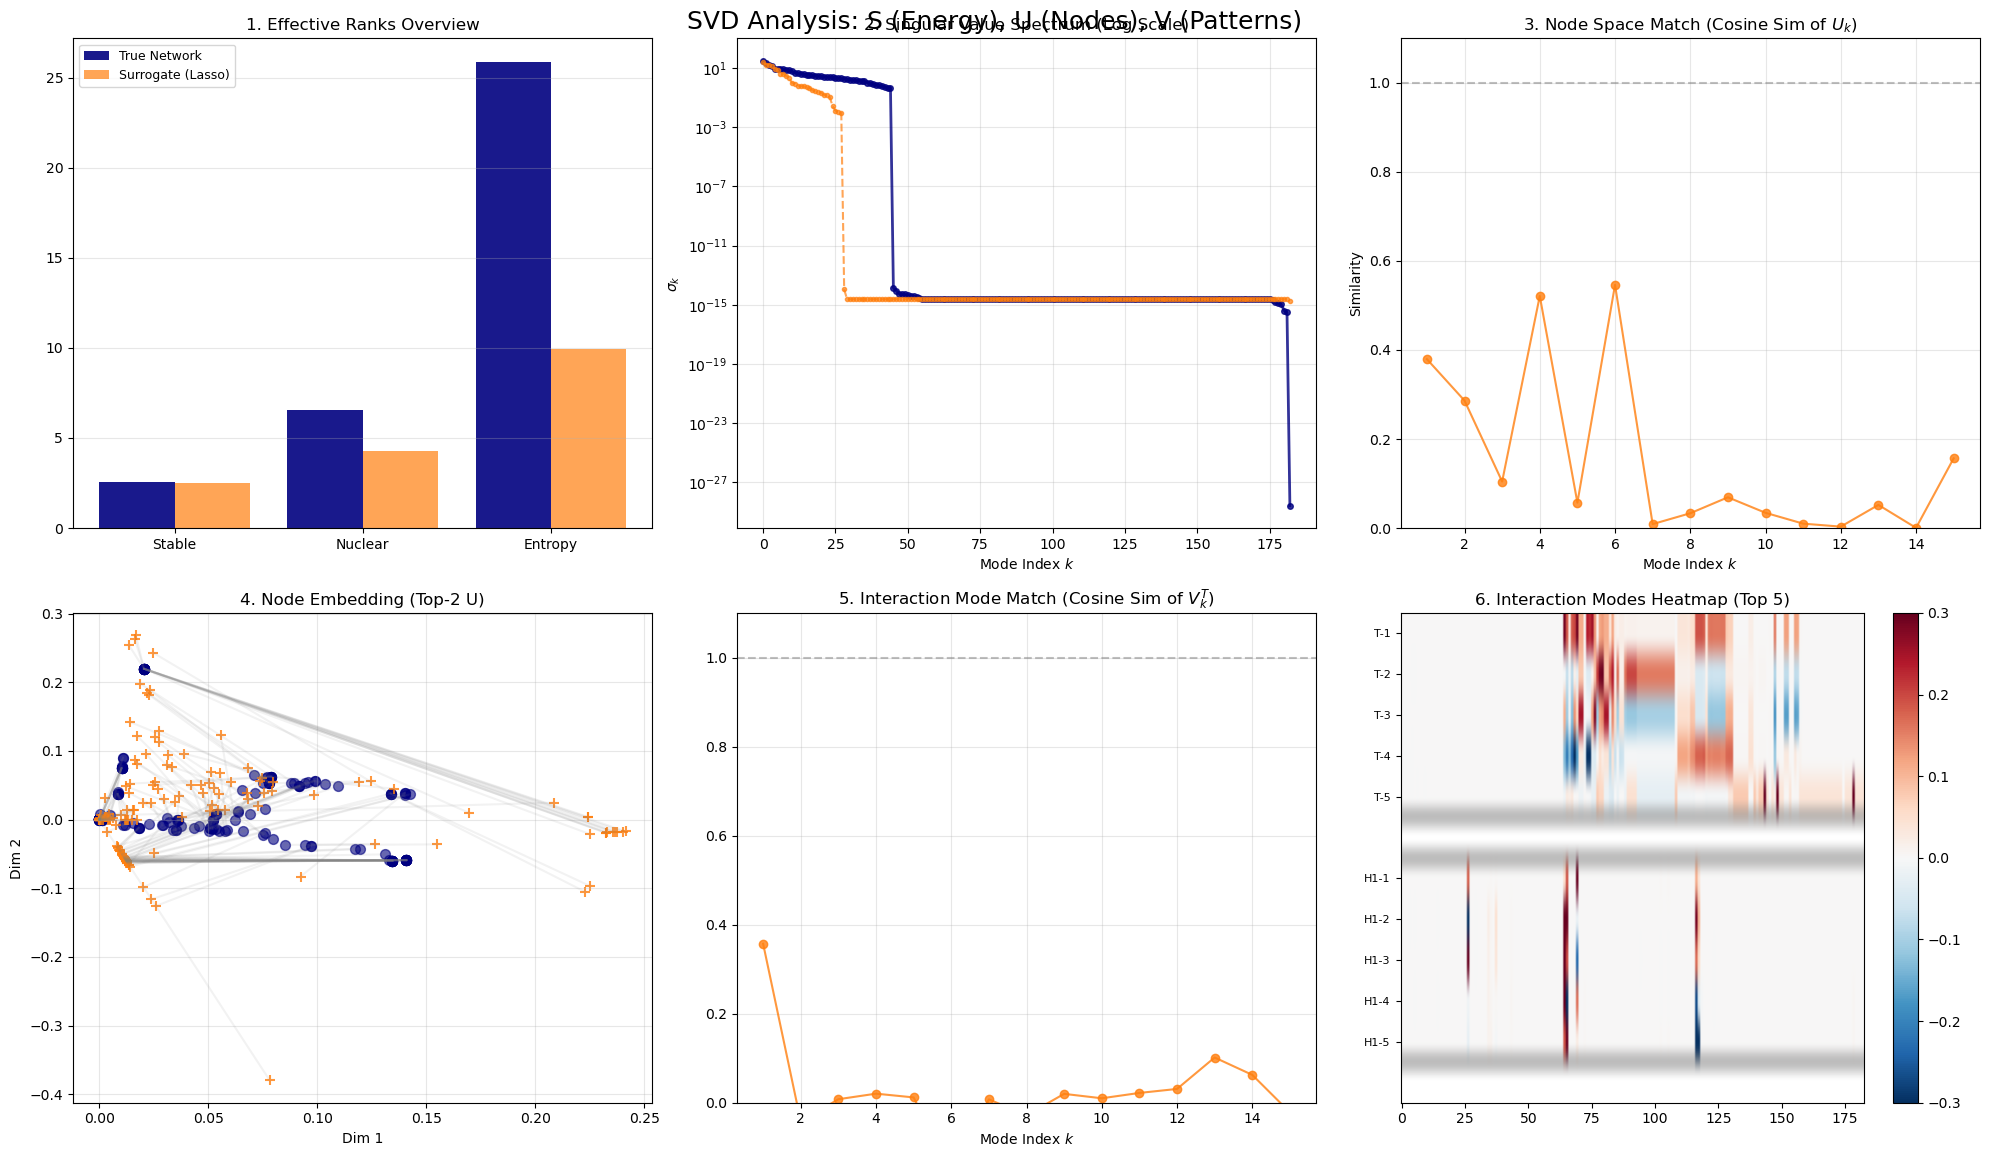

In [68]:
plot_balanced_svd_comparison(all_metrics, top_k_modes=15)

In [57]:
def verify_hypothesis(A_true, A_hat, metrics_hat, top_k=25):
    """
    验证 A_hat 的主要模式是否在 A_true 中也起作用（功能等效性验证）。
    
    参数:
    A_true: 真实邻接矩阵
    A_hat: 替代邻接矩阵
    metrics_hat: A_hat 的 metrics 字典 (包含 U, S, Vt)
    top_k: 验证前 k 个主模式
    """
    
    # 获取 A_hat 的核心信息
    # 注意: Vt 的行是右奇异向量 (Input Modes)
    # U 的列是左奇异向量 (Output Modes)
    Vt_hat = metrics_hat["Vt"]
    S_hat = metrics_hat["S"]
    U_hat = metrics_hat["U"]
    
    results = {
        "mode_indices": [],
        "errors_on_modes": [],
        "errors_on_random": [],
        "gains_ratio": [] # 比较放大倍数是否一致
    }
    
    print(f"--- 验证假设：对比 A_true 和 A_hat 在 Top-{top_k} 模式上的行为 ---")
    
    dim = A_true.shape[1]
    
    for i in range(top_k):
        # 1. 提取 A_hat 的第 i 个“刺激模式” (Input Mode)
        # 这是 A_hat 认为最重要的输入方向
        v_mode = Vt_hat[i, :] 
        
        # 2. 让两个网络分别处理这个刺激
        # 理论值: A_hat @ v ≈ sigma * u
        response_hat = A_hat @ v_mode
        response_true = A_true @ v_mode
        
        # 3. 计算两者反应的差异 (相对误差)
        # 如果猜想成立，A_true 应该产生和 A_hat 类似的反应
        diff = norm(response_hat - response_true)
        scale = norm(response_hat) + 1e-10 # 避免除零
        relative_error = diff / scale
        
        # 4. 对照组：随机向量
        v_rand = np.random.randn(dim)
        v_rand = v_rand / norm(v_rand) # 归一化
        res_rand_hat = A_hat @ v_rand
        res_rand_true = A_true @ v_rand
        diff_rand = norm(res_rand_hat - res_rand_true)
        scale_rand = norm(res_rand_hat) + 1e-10
        relative_error_rand = diff_rand / scale_rand
        
        # 5. 记录放大倍数 (Gain) 的差异
        # A_hat 的放大倍数就是 S[i]
        # A_true 对该模式的放大倍数是 ||A_true @ v||
        gain_true = norm(response_true)
        gain_hat = S_hat[i]
        gain_ratio = gain_true / gain_hat if gain_hat > 1e-10 else 0
        
        results["mode_indices"].append(i)
        results["errors_on_modes"].append(relative_error)
        results["errors_on_random"].append(relative_error_rand)
        results["gains_ratio"].append(gain_ratio)
        
        print(f"Mode {i+1}: 模式误差 = {relative_error:.4f} | 随机误差 = {relative_error_rand:.4f} | 增益比(True/Hat) = {gain_ratio:.2f}")

    # 可视化结果
    plt.figure(figsize=(10, 5))
    x = np.arange(top_k)
    width = 0.35
    
    plt.bar(x - width/2, results["errors_on_modes"], width, label='Error on Dominant Modes', color='green')
    plt.bar(x + width/2, results["errors_on_random"], width, label='Error on Random Vectors', color='gray')
    
    plt.xlabel('Mode Index (Rank)')
    plt.ylabel('Relative Prediction Error')
    plt.title('Functional Equivalence: Active Subspace vs Random Space')
    plt.xticks(x, [f"Mode {i+1}" for i in x])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    return results

--- 验证假设：对比 A_true 和 A_hat 在 Top-15 模式上的行为 ---
Mode 1: 模式误差 = 0.9488 | 随机误差 = 1.0175 | 增益比(True/Hat) = 0.49
Mode 2: 模式误差 = 1.2033 | 随机误差 = 1.8789 | 增益比(True/Hat) = 0.60
Mode 3: 模式误差 = 0.8091 | 随机误差 = 2.7547 | 增益比(True/Hat) = 0.32
Mode 4: 模式误差 = 1.0427 | 随机误差 = 1.0021 | 增益比(True/Hat) = 0.44
Mode 5: 模式误差 = 1.1889 | 随机误差 = 1.8721 | 增益比(True/Hat) = 0.71
Mode 6: 模式误差 = 0.9936 | 随机误差 = 1.8965 | 增益比(True/Hat) = 0.64
Mode 7: 模式误差 = 1.3085 | 随机误差 = 1.5782 | 增益比(True/Hat) = 0.78
Mode 8: 模式误差 = 1.3909 | 随机误差 = 1.5457 | 增益比(True/Hat) = 0.95
Mode 9: 模式误差 = 1.1413 | 随机误差 = 1.9483 | 增益比(True/Hat) = 1.39
Mode 10: 模式误差 = 1.1461 | 随机误差 = 1.4249 | 增益比(True/Hat) = 0.59
Mode 11: 模式误差 = 5.2159 | 随机误差 = 1.5769 | 增益比(True/Hat) = 5.10
Mode 12: 模式误差 = 2.2945 | 随机误差 = 2.0598 | 增益比(True/Hat) = 2.11
Mode 13: 模式误差 = 10.2430 | 随机误差 = 1.3758 | 增益比(True/Hat) = 10.16
Mode 14: 模式误差 = 6.5606 | 随机误差 = 2.2126 | 增益比(True/Hat) = 6.38
Mode 15: 模式误差 = 6.7144 | 随机误差 = 1.2468 | 增益比(True/Hat) = 6.61


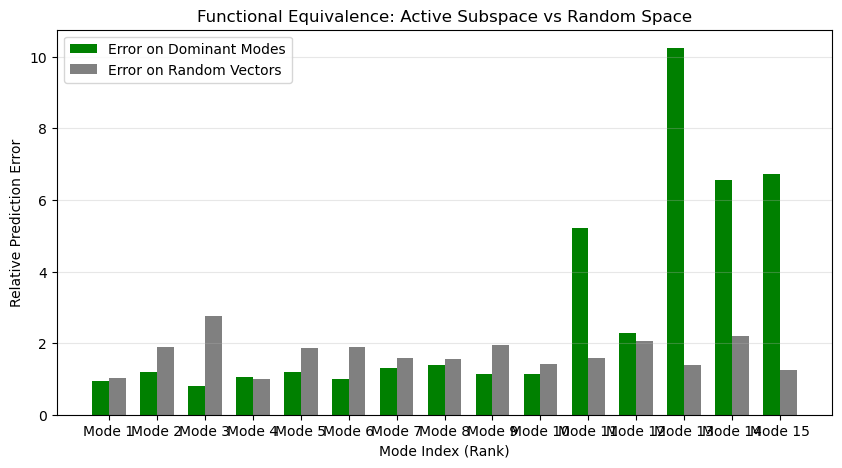

{'mode_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'errors_on_modes': [0.9487649841518213,
  1.2032862243568208,
  0.8090778358544827,
  1.0427000074378172,
  1.188889589014509,
  0.9936428905768806,
  1.3084561331833466,
  1.3908755292011805,
  1.1412629541433357,
  1.146129481877565,
  5.215923328642738,
  2.29451137117607,
  10.24303125652727,
  6.560634582752154,
  6.714419302375377],
 'errors_on_random': [1.0175010231787254,
  1.8788668872853507,
  2.7547185118040285,
  1.0021302454320853,
  1.872064156100028,
  1.8965088946959288,
  1.5781906766741867,
  1.5456755963446962,
  1.94826531040965,
  1.424892188176995,
  1.5768766156126302,
  2.059801778365576,
  1.3758493273295602,
  2.212556699830908,
  1.2467988134310393],
 'gains_ratio': [np.float64(0.4876161160979038),
  np.float64(0.6032653351251085),
  np.float64(0.32096218101527535),
  np.float64(0.43672007450462025),
  np.float64(0.71287052724213),
  np.float64(0.6404018629711761),
  np.float64(0.7821280781

In [58]:
# 使用示例 (假设你已经有了数据):
verify_hypothesis(A_true, A_hat, all_metrics[1], top_k=15)

In [80]:
def analyze_multi_mode_drivers(metrics, num_modes=5, top_k=15):
    """
    分析前 n 个模式 (Modes) 的关键驱动节点及其拓扑性质。
    
    参数:
    metrics : dict, 包含 'Vt', 'S', 'topology' 的数据包
    num_modes : int, 分析前多少个模式 (默认 5)
    top_k : int, 每个模式展示前多少个节点
    
    返回:
    df_all : pd.DataFrame, 包含所有模式关键节点的完整数据表
    """
    # 基础数据提取
    Vt = metrics['Vt']
    S = metrics['S']
    degrees = metrics['topology']['in_degrees']
    network_name = metrics['name']
    
    # 限制模式数量不超过实际秩
    num_modes = min(num_modes, len(S))
    
    # 数据容器
    all_data = []
    
    # ==========================================
    # 1. 循环提取每个 Mode 的数据
    # ==========================================
    for m in range(num_modes):
        v_vec = Vt[m, :]
        sigma = S[m]
        
        # 排序：按绝对值大小寻找贡献最大的节点
        sorted_indices = np.argsort(np.abs(v_vec))[::-1]
        top_indices = sorted_indices[:top_k]
        
        mode_energy = sigma**2
        vec_energy = np.sum(v_vec**2) # 应该是 1.0
        
        for rank, idx in enumerate(top_indices):
            val = v_vec[idx]
            deg = degrees[idx]
            
            # 计算度百分位
            pct = (np.sum(degrees < deg) / len(degrees)) * 100
            
            all_data.append({
                "Mode": f"Mode {m+1}",
                "Sigma": sigma,
                "Node ID": idx,
                "Coefficient": val,
                "Abs Coeff": np.abs(val),
                "Sign": "Positive" if val > 0 else "Negative",
                "Degree": int(deg),
                "Degree %Tile": pct,
                "Rank in Mode": rank + 1
            })
            
    df_all = pd.DataFrame(all_data)
    
    # ==========================================
    # 可视化 A: 每个 Mode 的驱动节点 (Subplots)
    # ==========================================
    # 动态调整画布高度
    fig, axes = plt.subplots(num_modes, 1, figsize=(12, 3 * num_modes), sharex=False)
    if num_modes == 1: axes = [axes]
    
    fig.suptitle(f"Top {top_k} Drivers for First {num_modes} Modes\nNetwork: {network_name}", y=1.005, fontsize=16)
    
    for m, ax in enumerate(axes):
        mode_label = f"Mode {m+1}"
        subset = df_all[df_all["Mode"] == mode_label]
        sigma_val = subset["Sigma"].iloc[0]
        
        # 绘制条形图
        sns.barplot(x="Node ID", y="Coefficient", hue="Sign", data=subset,
                    palette={"Positive": "crimson", "Negative": "dodgerblue"},
                    dodge=False, ax=ax, order=subset["Node ID"]) # 保持排序顺序
        
        # 装饰
        ax.set_title(f"{mode_label} (Singular Value $\sigma_{m+1} = {sigma_val:.2f}$)", fontsize=13, pad=5)
        ax.set_xlabel("")
        ax.set_ylabel("Driver Score ($v_{ki}$)")
        ax.axhline(0, color='black', lw=0.8)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.legend(loc='upper right', fontsize=8, title=None)
        
        # 在柱子上标注度数 (Degree)
        # 这能让你直接看到：这个柱子虽然高，但它的度数是多少？
        for p, deg in zip(ax.patches, subset["Degree"]):
            height = p.get_height()
            # 自动调整标注位置 (正数在上方，负数在下方)
            offset = 5 if height > 0 else -15
            ax.annotate(f"k={deg}", 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha = 'center', va = 'center', 
                        xytext = (0, offset), 
                        textcoords = 'offset points',
                        fontsize=9, color='black', fontweight='bold')

    plt.tight_layout()
    plt.show()
    
    # ==========================================
    # 可视化 B: 驱动节点在度分布中的位置 (Boxplot)
    # ==========================================
    # 这个图回答：Mode 1 的驱动者是 Hub 吗？Mode 2 呢？
    plt.figure(figsize=(10, 6))
    
    # 1. 画全网度分布背景 (灰色小提琴或箱线图)
    # 为了对比，我们在背景里画一条全网平均度的线
    avg_deg = np.mean(degrees)
    plt.axhline(avg_deg, color='gray', linestyle='--', label=f'Network Avg Degree ({avg_deg:.1f})')
    
    # 2. 画不同 Mode 的驱动节点的度分布
    sns.stripplot(x="Mode", y="Degree", data=df_all, 
                  jitter=True, size=8, hue="Sign", 
                  palette={"Positive": "crimson", "Negative": "dodgerblue"}, alpha=0.8)
    
    # 叠加一个箱线图看统计趋势
    sns.boxplot(x="Mode", y="Degree", data=df_all, color='white', width=0.3, showfliers=False, boxprops={'alpha': 0.3})

    plt.yscale('log') # 度分布通常跨度大，用对数轴更清晰
    plt.title("Are Drivers Hubs? Degree Distribution of Top Drivers per Mode", fontsize=14)
    plt.ylabel("Node Degree (Log Scale)")
    plt.xlabel("Interaction Mode")
    plt.grid(axis='y', which='both', linestyle=':', alpha=0.5)
    plt.legend(title="Interaction Sign")
    
    plt.tight_layout()
    plt.show()
    
    return df_all

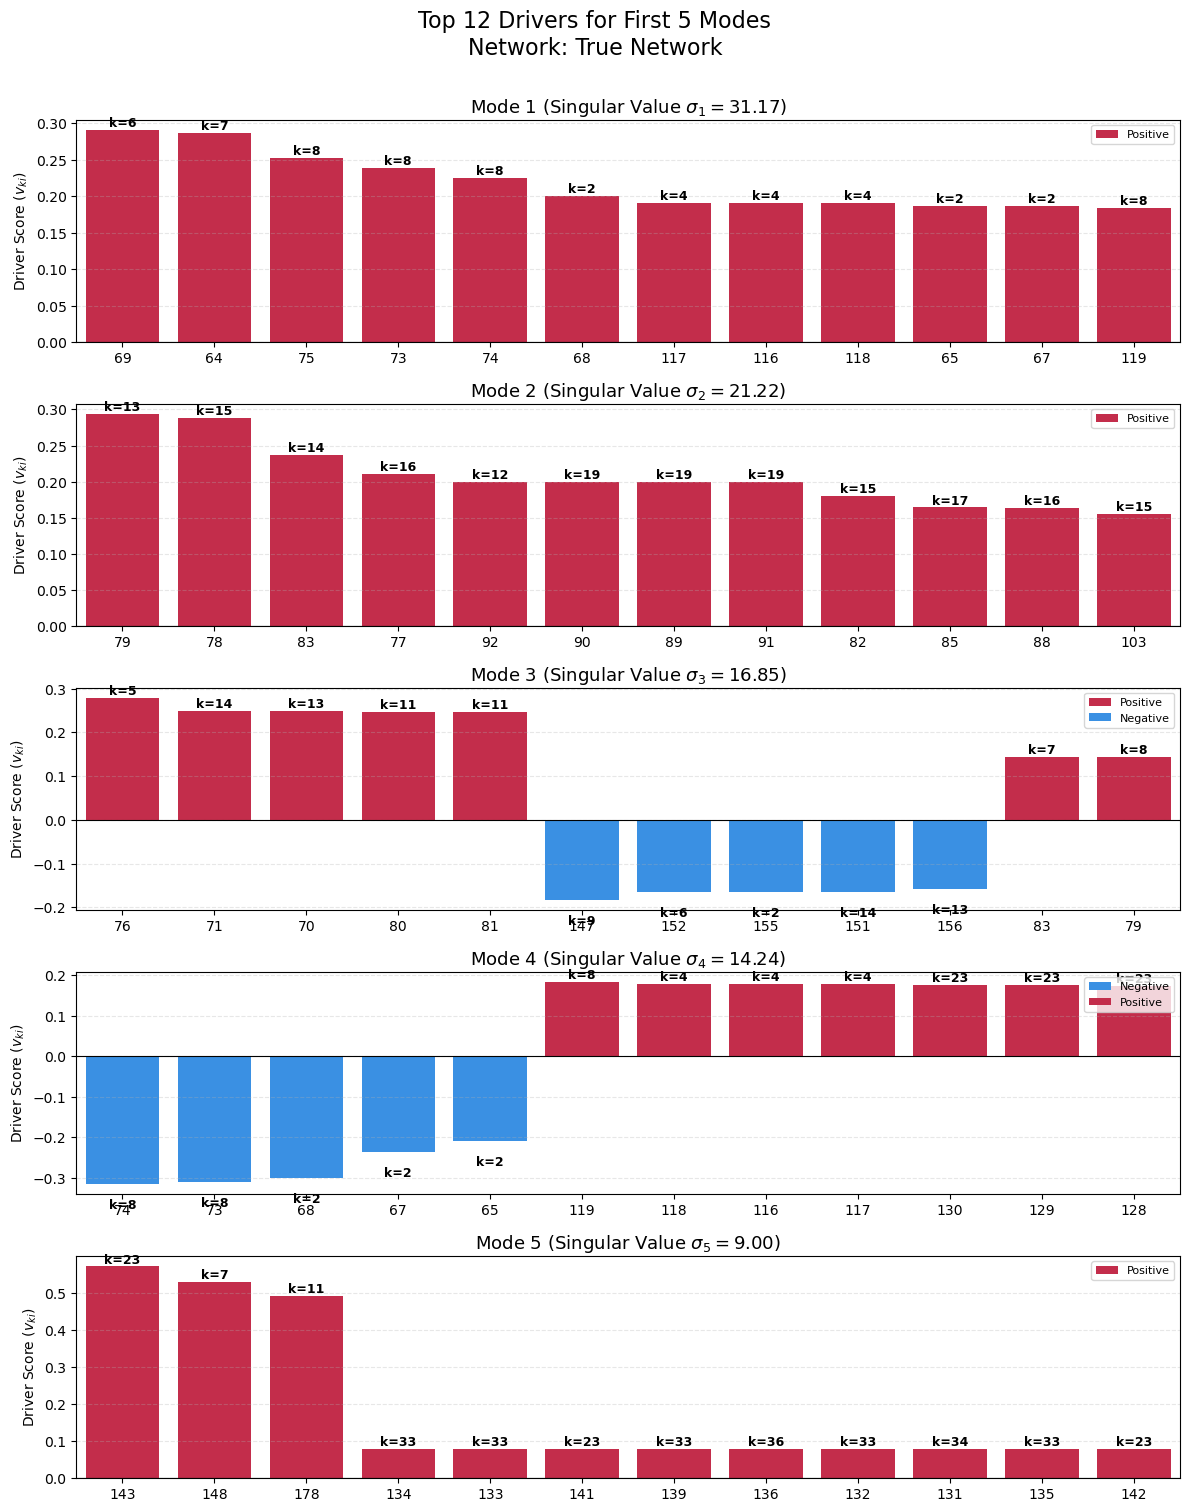

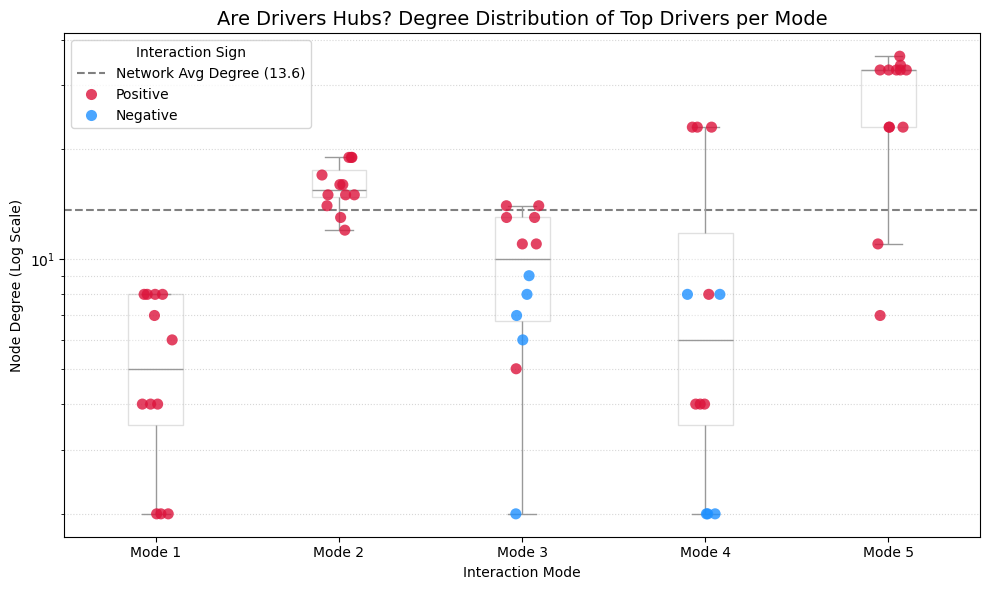

In [81]:
df_modes_true = analyze_multi_mode_drivers(all_metrics[0], num_modes=5, top_k=12)

In [82]:
df_modes_true

,Mode,Sigma,Node ID,Coefficient,Abs Coeff,Sign,Degree,Degree %Tile,Rank in Mode
0,Mode 1,31.170636,69,0.290535,0.290535,Positive,6,27.868852,1
1,Mode 1,31.170636,64,0.287204,0.287204,Positive,7,29.508197,2
2,Mode 1,31.170636,75,0.252613,0.252613,Positive,8,40.437158,3
3,Mode 1,31.170636,73,0.238468,0.238468,Positive,8,40.437158,4
4,Mode 1,31.170636,74,0.224822,0.224822,Positive,8,40.437158,5
5,Mode 1,31.170636,68,0.200179,0.200179,Positive,2,1.092896,6
6,Mode 1,31.170636,117,0.191007,0.191007,Positive,4,22.950820,7
7,Mode 1,31.170636,116,0.191007,0.191007,Positive,4,22.950820,8
8,Mode 1,31.170636,118,0.191007,0.191007,Positive,4,22.950820,9
9,Mode 1,31.170636,65,0.186953,0.186953,Positive,2,1.092896,10


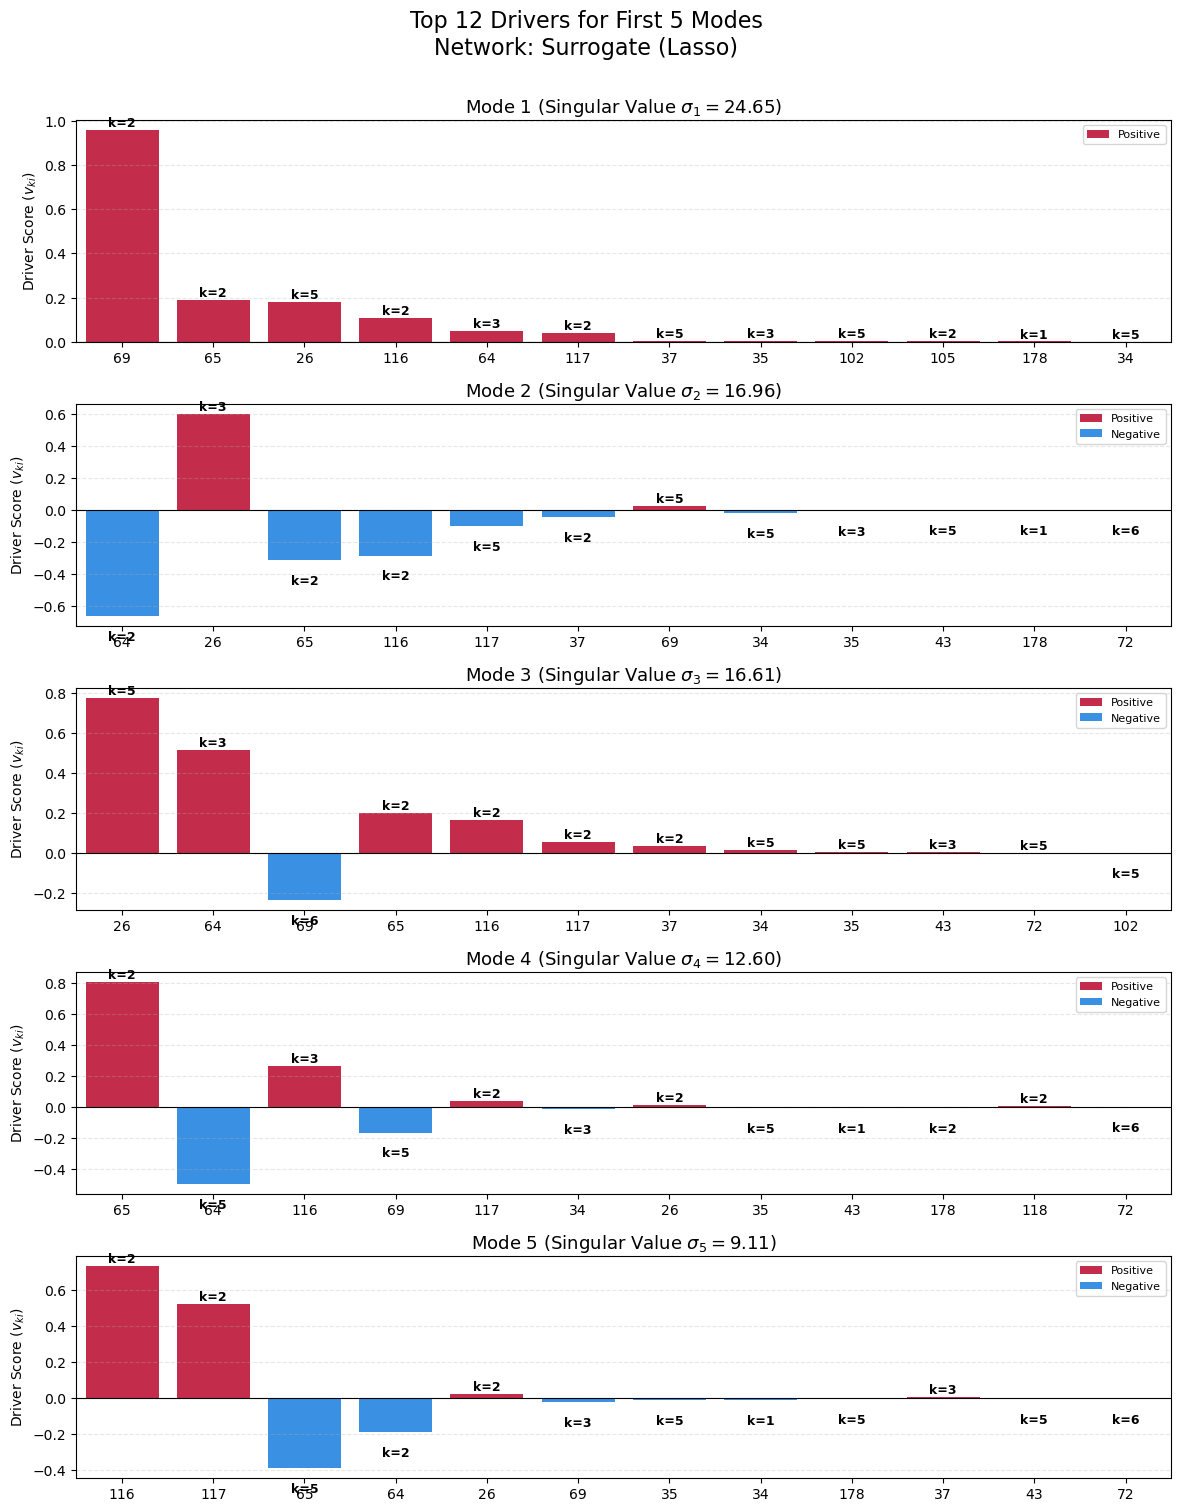

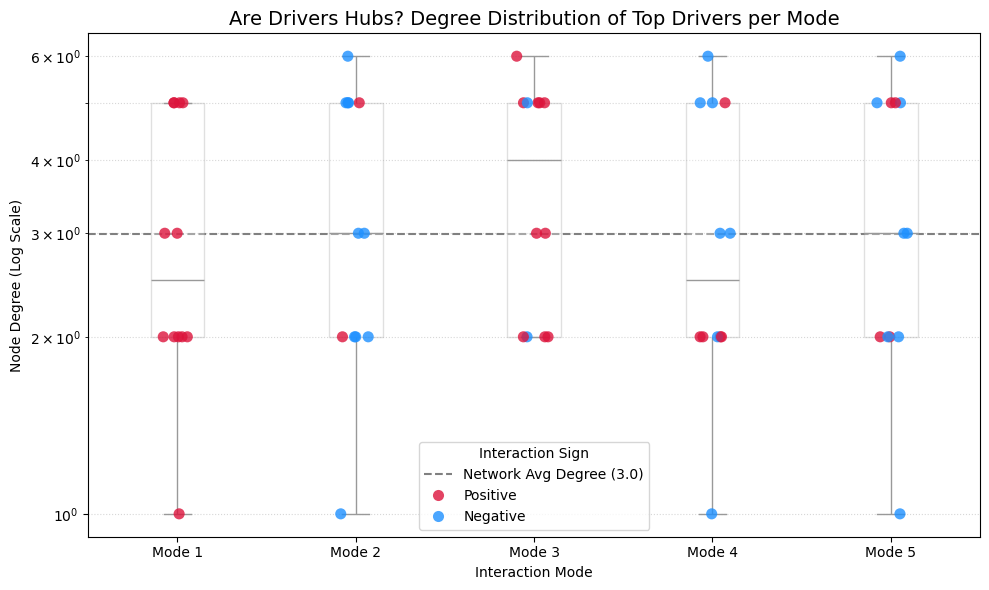

In [83]:
df_modes_hat = analyze_multi_mode_drivers(all_metrics[1], num_modes=5, top_k=12)

In [85]:
df_modes_hat

,Mode,Sigma,Node ID,Coefficient,Abs Coeff,Sign,Degree,Degree %Tile,Rank in Mode
0,Mode 1,24.649140,69,0.957066,0.957066,Positive,2,28.415301,1
1,Mode 1,24.649140,65,0.189082,0.189082,Positive,2,28.415301,2
2,Mode 1,24.649140,26,0.179912,0.179912,Positive,5,74.863388,3
3,Mode 1,24.649140,116,0.106974,0.106974,Positive,2,28.415301,4
4,Mode 1,24.649140,64,0.051556,0.051556,Positive,3,47.540984,5
5,Mode 1,24.649140,117,0.041743,0.041743,Positive,2,28.415301,6
6,Mode 1,24.649140,37,0.004256,0.004256,Positive,5,74.863388,7
7,Mode 1,24.649140,35,0.003944,0.003944,Positive,3,47.540984,8
8,Mode 1,24.649140,102,0.002961,0.002961,Positive,5,74.863388,9
9,Mode 1,24.649140,105,0.002674,0.002674,Positive,2,28.415301,10


In [93]:
def plot_graph_from_adj(A):
    A = np.array(A)
    G = nx.from_numpy_array(A)

    plt.figure(figsize=(8, 8))  # 图大一点
    pos = nx.spring_layout(G, k=1.2, iterations=300)  # 更松散、布局更好

    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=30,   # 更小的节点
        font_size=10
    )

    plt.show()

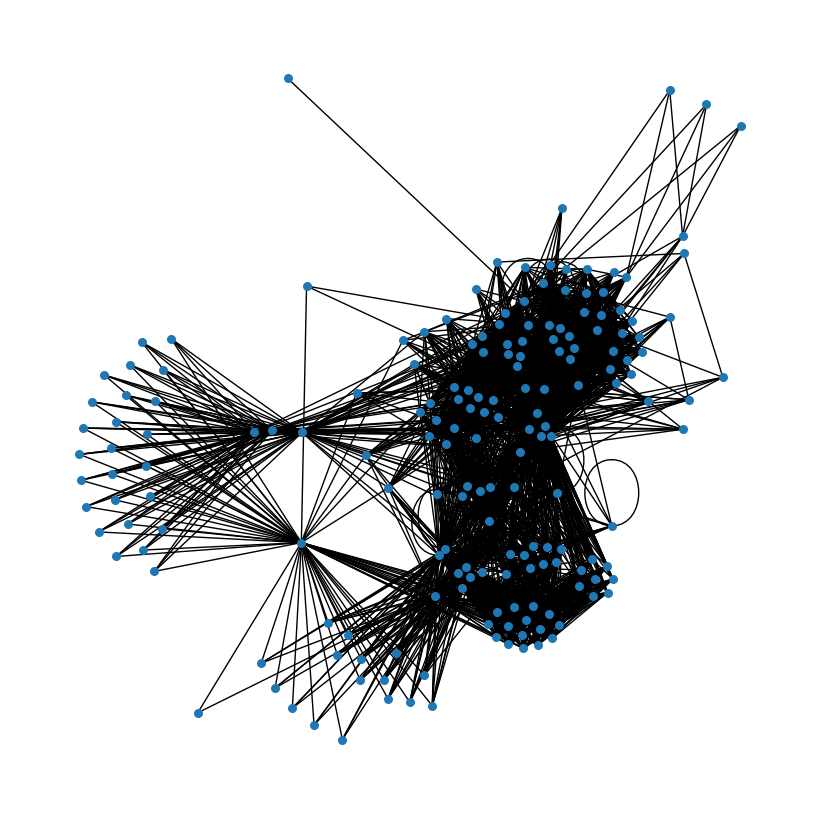

In [98]:
plot_graph_from_adj(A_true)

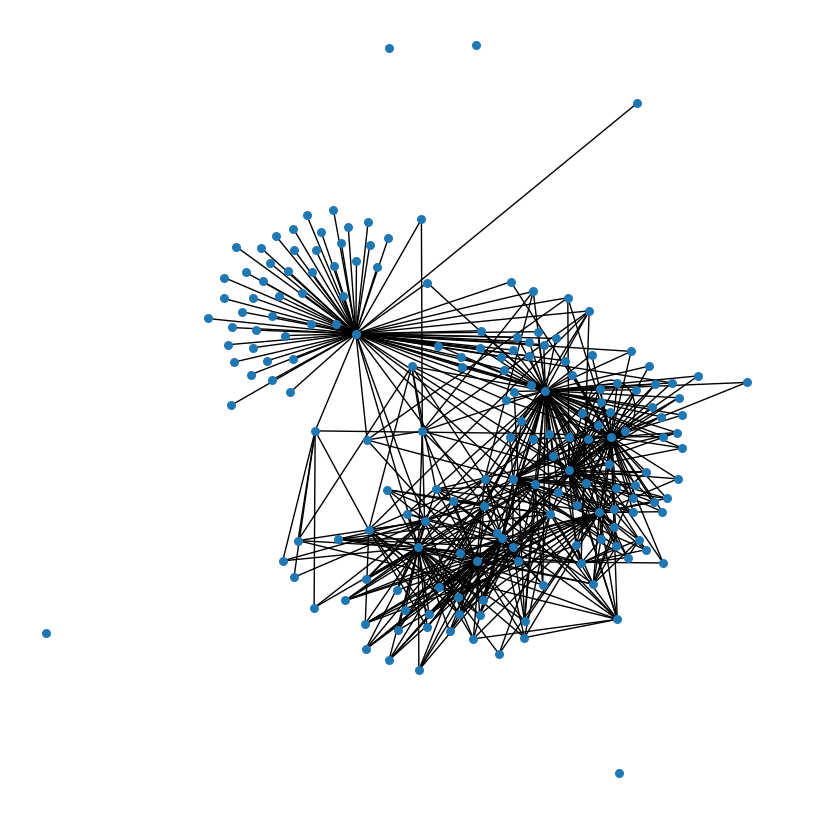

In [94]:
plot_graph_from_adj(A_hat)

In [104]:
def project_matrix_subspace(target_matrix, basis_matrix, k=10):
    """
    【投影法】利用 basis_matrix 定义的 k 维子空间，对 target_matrix 进行滤波。
    
    物理含义:
    强制 target_matrix 的能量流动只能发生在 basis_matrix 允许的 "管道" (模式) 里。
    
    参数:
    -------
    target_matrix : np.array
        被操作的矩阵 (如 A_true)。
    basis_matrix : np.array
        定义方向/模式的矩阵 (如 A_hat)。
    k : int
        保留的模式数量 (即 rank)。
        
    返回:
    -------
    A_proj : np.array
        投影后的矩阵 (非负)。
    """
    # 1. 提取基底 (Stage)
    # 这里的 U 和 Vt 定义了合法的"流入"和"流出"方向
    U, _, Vt = svd(basis_matrix, full_matrices=False)
    
    # 截取前 k 个模式
    # U_k: (N, k), Vt_k: (k, N)
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    
    # 2. 投影运算 (Projection)
    # 公式: A_proj = P_U * A_target * P_V
    # 其中 P_U = U U.T, P_V = V.T V (注意 Vt 已经是转置后的)
    
    # Step A: 将 target 映射到 k 维特征空间
    # 计算 target 在这个子空间里的"投影分量"
    # latent_core shape: (k, k)
    latent_core = U_k.T @ target_matrix @ Vt_k.T
    
    # Step B: 重构回 N 维物理空间
    A_proj = U_k @ latent_core @ Vt_k
    
    # 3. 物理约束
    # 投影会产生微小的数学噪声(负值)，需归零
    A_proj = np.maximum(A_proj, 0)
    
    print(f"[Projection] Subspace Rank: {k}")
    print(f"  - Original Edges: {np.count_nonzero(target_matrix)}")
    print(f"  - Projected Edges: {np.count_nonzero(A_proj)} (Usually dense)")
    
    return A_proj

In [110]:
A_true_proj_on_hat = project_matrix_subspace(A_true, A_hat, k=10)
A_true_proj_on_hat

[Projection] Subspace Rank: 10
  - Original Edges: 2494
  - Projected Edges: 5591 (Usually dense)


array([[8.96125705e-18, 0.00000000e+00, 1.99617327e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.95524222e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.18573684e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 4.10158849e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.04530565e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [111]:
print("Predicting future dynamics on A_true_proj_on_hat...")
T_pred_steps = T_total_steps - T_train_steps
X_true_proj_on_hat_future_pred = model.simulate(A_true_proj_on_hat, T_steps=T_pred_steps, init_state=x0_pred)
X_true_proj_on_hat_full_pred = np.vstack([X_train, X_true_proj_on_hat_future_pred])
print("A_true_proj_on_hat simulation finish")

Predicting future dynamics on A_true_proj_on_hat...
A_true_proj_on_hat simulation finish


C:\Users\liu.xuanc\AppData\Local\Temp\ipykernel_19420\1268715552.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')(np.linspace(0, 1, num_plot_nodes))


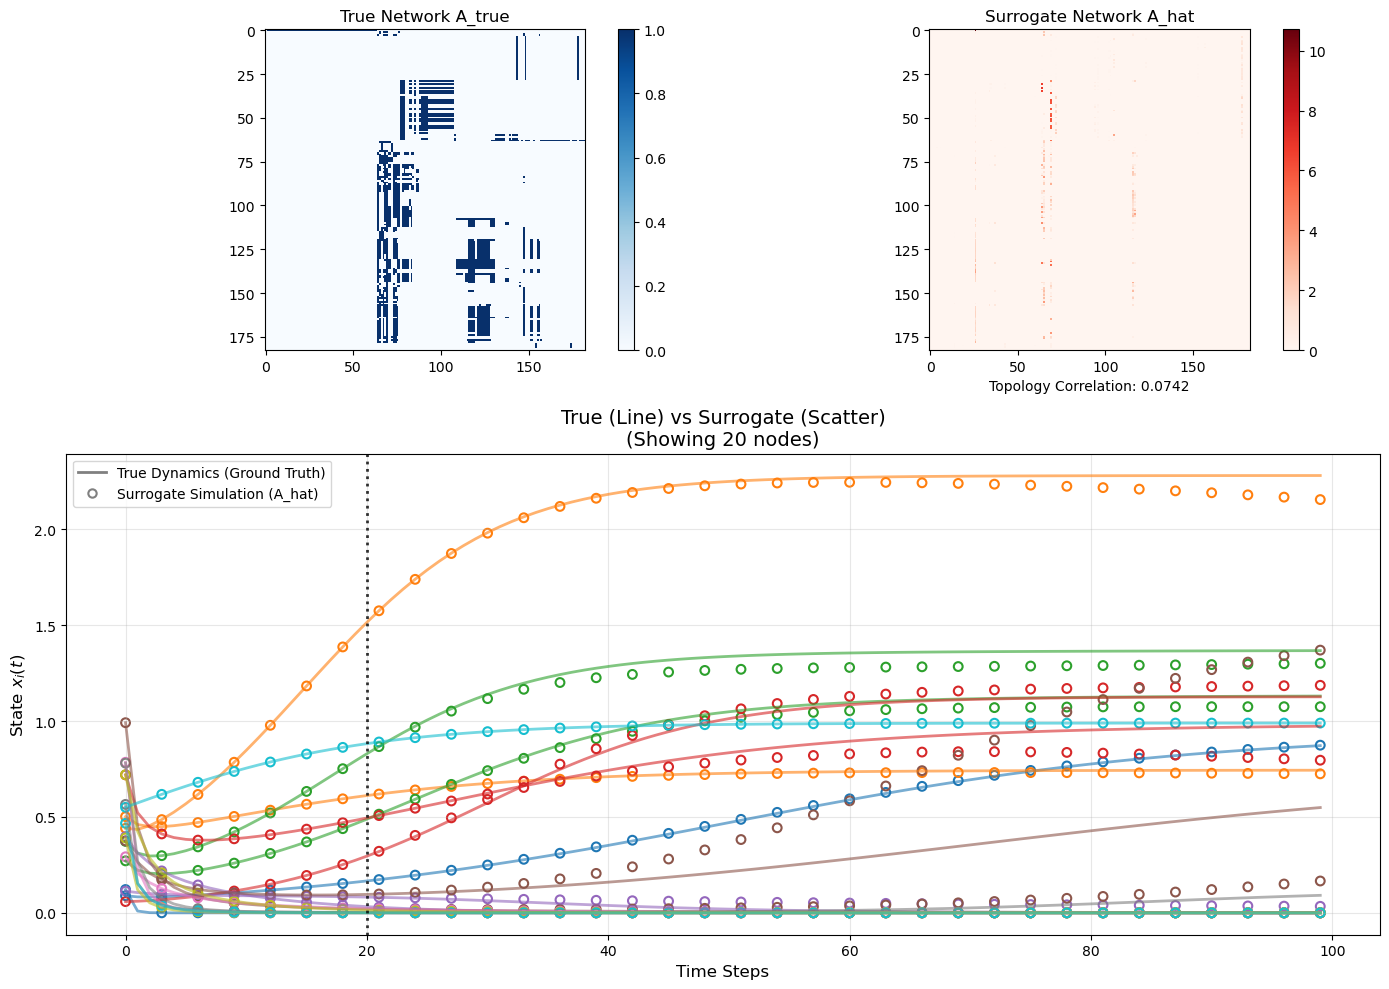

In [14]:
# Figure
fig = plt.figure(figsize=(14, 10))
grid = plt.GridSpec(2, 2, height_ratios=[1, 1.5])

# --- 图 1: 网络拓扑对比 (保持不变) ---
ax1 = fig.add_subplot(grid[0, 0])
cax1 = ax1.imshow(A_true, cmap='Blues', interpolation='nearest')
ax1.set_title("True Network A_true")
fig.colorbar(cax1, ax=ax1)

ax2 = fig.add_subplot(grid[0, 1])
cax2 = ax2.imshow(A_hat, cmap='Reds', interpolation='nearest')
ax2.set_title("Surrogate Network A_hat")
fig.colorbar(cax2, ax=ax2)

# 计算拓扑相关性
flatten_true = A_true.flatten()
flatten_hat = A_hat.flatten()
corr = np.corrcoef(flatten_true, flatten_hat)[0, 1]
ax2.set_xlabel(f"Topology Correlation: {corr:.4f}")

# --- 图 2: 动力学轨迹对比 (核心修改) ---
ax3 = fig.add_subplot(grid[1, :])

# 1. 【自定义设置】: 在这里修改你想要画的节点数量
num_plot_nodes = 20   # Uumber of nodes being plotted
scatter_interval = 3 # Time steps for plotting each nodes

# 自动选择节点和颜色
if num_plot_nodes > N: num_plot_nodes = N
# 均匀选择节点索引
nodes_to_plot = np.linspace(0, N-1, num_plot_nodes, dtype=int)
# 生成颜色映射 (使用 'tab10', 'jet', 'viridis' 等)
colors = cm.get_cmap('tab10')(np.linspace(0, 1, num_plot_nodes))

time_steps = np.arange(T_total_steps)

for idx, node_idx in enumerate(nodes_to_plot):
    color = colors[idx]
    
    # A. 绘制真实轨迹 (实线)
    # alpha=0.6 让线条稍微透明一点，突显上面的散点
    ax3.plot(time_steps, X_obs[:, node_idx], 
             color=color, linestyle='-', linewidth=2, alpha=0.6,
             label=f'Node {node_idx} (True)')
    
    # B. 绘制 Surrogate 轨迹 (散点)
    # 使用切片 [::scatter_interval] 进行稀疏化，防止点太密成线
    sparse_indices = np.arange(0, T_total_steps, scatter_interval)
    
    ax3.scatter(time_steps[sparse_indices], X_full_pred[sparse_indices, node_idx], 
                edgecolors=color,    # 边框颜色与实线一致
                facecolors='none',   # 内部透明 (空心圆)
                marker='o',          # 圆圈形状
                s=40,                # 点的大小
                linewidth=1.5,       # 边框粗细
                label=f'Node {node_idx} (Surrogate)' if idx == 0 else None) 
                # label 仅加一次，避免图例太长

# 添加训练/预测分界线
ax3.axvline(x=T_train_steps, color='k', linestyle=':', linewidth=2, alpha=0.8)
# ax3.text(T_train_steps + 2, np.max(X_obs)*0.95, 'Prediction Start', fontsize=12, fontweight='bold')

ax3.set_title(f"True (Line) vs Surrogate (Scatter)\n(Showing {num_plot_nodes} nodes)", fontsize=14)
ax3.set_xlabel("Time Steps", fontsize=12)
ax3.set_ylabel("State $x_i(t)$", fontsize=12)

# 优化图例：只显示一次 True 和 Surrogate 的代表，而不是每个节点都显示两遍
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=2, linestyle='-'),
                Line2D([0], [0], color='gray', marker='o', linestyle='None', 
                       markerfacecolor='none', markeredgewidth=1.5)]
ax3.legend(custom_lines, ['True Dynamics (Ground Truth)', 'Surrogate Simulation (A_hat)'], 
           loc='upper left', fontsize=10)

ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [107]:
def filter_network_by_nodes(target_matrix, basis_matrix, k_modes=10, top_x_per_mode=15, neighbor_strategy='induced'):
    """
    【筛选法】根据 basis_matrix 的主导模式筛选 target_matrix 中的关键节点。
    
    参数:
    -------
    target_matrix : np.array
        被操作的矩阵 (如 A_true)。
    basis_matrix : np.array
        用于识别关键节点的参考矩阵 (如 A_hat)。
    k_modes : int
        考虑前多少个 Sigma 对应的模式。
    top_x_per_mode : int
        每个模式中选出多少个贡献最大的节点。
    neighbor_strategy : str
        'induced' : (严格) 只保留被选节点**之间**的连边。
                    这是测试"富人俱乐部"是否能独立驱动动力学。
        'ego'     : (您的原始设想) 保留被选节点及其**所有邻居**的连边。
                    这保留了更多信息，但也引入了更多"非骨架"噪音。
        
    返回:
    -------
    A_filtered : np.array
        筛选后的矩阵 (其余位置置 0，维度保持 N x N 不变)。
    """
    N = target_matrix.shape[0]
    
    # 1. 识别关键节点 (Key Drivers)
    # 使用 basis_matrix 的 Vt (发送端/Source) 来识别
    _, _, Vt = svd(basis_matrix, full_matrices=False)
    
    selected_nodes = set()
    
    # 遍历前 k 个模式
    for i in range(k_modes):
        v_vec = Vt[i, :]
        # 找出绝对值最大的索引
        top_indices = np.argsort(np.abs(v_vec))[::-1][:top_x_per_mode]
        selected_nodes.update(top_indices)
        
    selected_nodes = list(selected_nodes)
    num_selected = len(selected_nodes)
    
    # 2. 构建掩膜 (Mask)
    mask = np.zeros((N, N), dtype=bool)
    
    if neighbor_strategy == 'induced':
        # 策略 A: 仅保留核心节点内部的连接 (Sub-graph)
        # Mask[i, j] = True 仅当 i 和 j 都在 selected_nodes 里
        # 利用网格索引快速构建
        grid_idx = np.ix_(selected_nodes, selected_nodes)
        mask[grid_idx] = True
        
    elif neighbor_strategy == 'ego':
        # 策略 B: 保留核心节点及其所有邻居 (Ego-graph)
        # Mask[i, j] = True 只要 i 或 j 有一个是核心节点
        # 这意味着保留了核心节点的所有入边和出边
        for node in selected_nodes:
            mask[node, :] = True # 保留该节点的出边
            mask[:, node] = True # 保留该节点的入边
            
    else:
        raise ValueError("Strategy must be 'induced' or 'ego'")
        
    # 3. 应用筛选
    A_filtered = target_matrix * mask
    
    print(f"[Selection] Strategy: {neighbor_strategy}")
    print(f"  - Modes Considered: {k_modes}, Top-X per mode: {top_x_per_mode}")
    print(f"  - Unique Nodes Selected: {num_selected}/{N} ({num_selected/N:.1%})")
    print(f"  - Edges Retained: {np.count_nonzero(A_filtered)} / {np.count_nonzero(target_matrix)}")
    
    return A_filtered

In [25]:
def calculate_ccdf(degrees):
    """
    辅助函数：计算互补累积分布 P(D >= k)
    """
    degrees = np.sort(degrees)
    n = len(degrees)
    # y轴：从 1 降到 1/n
    y = np.arange(n, 0, -1) / n
    return degrees, y

def plot_topology_comparison(metrics_list, figsize=(10, 6)):
    """
    专门用于对比拓扑结构（度分布）的绘图函数。
    
    输入:
    metrics_list : 包含 'topology' 数据的字典列表 (由 get_comprehensive_metrics 生成)
                   metrics_list[0] 默认为 True Network
    """
    # 基础设置
    n_matrices = len(metrics_list)
    if n_matrices < 2:
        print("At least two networks")
        return

    mt = metrics_list[0]      # Ground Truth
    m_hats = metrics_list[1:] # Surrogates
    
    color_true = 'navy'
    colors = [color_true] + [cm.tab10(i+1) for i in range(len(m_hats))]
    
    # 创建画布
    fig, ax = plt.subplots(figsize=figsize)

    # Surrogate Networks
    deg_t, prob_t = calculate_ccdf(mt['topology']['in_degrees'])
    
    # 使用 'step' 绘图，where='post' 是标准的生存分析/CCDF 画法
    ax.step(deg_t, prob_t, where='post', 
            color=colors[0], lw=3, alpha=0.9, 
            label=f"{mt['name']} (Edges: {mt['topology']['num_edges']})")
    
    # Surrogate Networks
    for idx, mh in enumerate(m_hats):
        deg_h, prob_h = calculate_ccdf(mh['topology']['in_degrees'])
        
        # 使用虚线或点线区分
        ax.step(deg_h, prob_h, where='post', 
                color=colors[idx+1], lw=2, linestyle='--', alpha=0.8,
                label=f"{mh['name']} (Edges: {mh['topology']['num_edges']})")
        
        # KS Statistic
    
    # --------------------------------------------------------
    # 图表美化
    # --------------------------------------------------------
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel("Degree ($k$)", fontsize=12)
    ax.set_ylabel("CCDF $P(K \geq k)$", fontsize=12)
    ax.set_title("Topology Comparison: Degree Distribution", fontsize=14, fontweight='bold')
    
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend(fontsize=10, loc='lower left') 
    
    plt.tight_layout()
    plt.show()

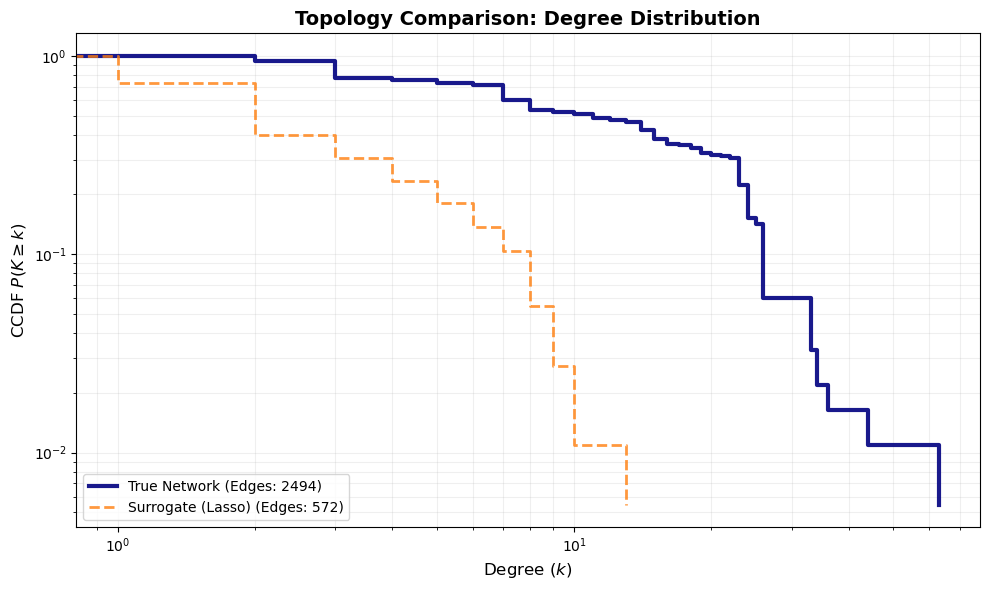

In [29]:
plot_topology_comparison(all_metrics, figsize=(10, 6))

In [17]:
def calculate_topology_auc(A_true, A_hat, mask_diagonal=True):
    # 1. 数据预处理
    if mask_diagonal:
        # 获取非对角线元素的索引
        N = A_true.shape[0]
        mask = ~np.eye(N, dtype=bool)
        
        # 只提取非对角线元素
        flat_true = A_true[mask]
        flat_hat = A_hat[mask]
    else:
        # 展平整个矩阵
        flat_true = A_true.flatten()
        flat_hat = A_hat.flatten()
        
    # 2. 构建二分类标签 (y_true)
    # 论文指出："If there is a directed link... then a_ij > 0, otherwise a_ij = 0" [cite: 635]
    # 且 AUC 是衡量 "Topological similarity" [cite: 1001]，即只看有没有边。
    y_true = (flat_true > 0).astype(int)
    
    # 3. 准备预测分数 (y_score)
    # A_hat 的权重值充当“存在边的概率或置信度”
    y_scores = flat_hat
    
    # 4. 计算 AUC
    # roc_auc_score 会自动处理所有可能的阈值 epsilon
    try:
        auc_val = roc_auc_score(y_true, y_scores)
    except ValueError:
        # 如果 y_true 全是 0 或 全是 1（例如空网络或全连接网络），AUC 无法定义
        print("警告: A_true 中只有一类标签（全有边或全无边），无法计算 AUC。")
        return 0.5
        
    return auc_val

In [18]:
auc = calculate_topology_auc(A_true, A_hat)
print(f"AUC: {auc:.4f}")

AUC: 0.4995


In [132]:
def plot_network_diff(A_true, A_hat, threshold=0.0):
    """
    绘制 A_true 和 A_hat 之间差异的网络图：
    - green: 两者都有
    - red:   只在 A_true
    - blue:  只在 A_hat
    """

    # ---- Step 1: 二值化邻接矩阵 ----
    A1 = (A_true > threshold).astype(int)
    A2 = (A_hat > threshold).astype(int)

    n = A1.shape[0]

    # ---- Step 2: 求三类边 ----
    edges_true = set(zip(*np.where(A1 == 1)))
    edges_hat  = set(zip(*np.where(A2 == 1)))

    edges_common = edges_true & edges_hat
    edges_only_true = edges_true - edges_hat
    edges_only_hat  = edges_hat - edges_true

    # ---- Step 3: 构建图 ----
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(edges_common)
    G.add_edges_from(edges_only_true)
    G.add_edges_from(edges_only_hat)

    # ---- Step 4: 节点位置 ----
    pos = nx.spring_layout(G, seed=0)

    # ---- Step 5: 绘图 ----
    plt.figure(figsize=(10, 10))

    # 节点（更小）
    nx.draw_networkx_nodes(
        G, pos,
        node_size=40,
        node_color="lightgrey"
    )

    # 仅 A_true 边（红色）
    nx.draw_networkx_edges(
        G, pos,
        edgelist=list(edges_only_true),
        width=0.8, edge_color="#d62728", alpha=0.4
    )

    # 仅 A_hat 边（蓝色）
    nx.draw_networkx_edges(
        G, pos,
        edgelist=list(edges_only_hat),
        width=0.8, edge_color="#1f77b4", alpha=0.4
    )

    # 共同边（绿色，变细）
    nx.draw_networkx_edges(
        G, pos,
        edgelist=list(edges_common),
        width=0.8, edge_color="#2ca02c"
    )

    # 不显示节点标签
    # nx.draw_networkx_labels(G, pos)

    # 图例
    plt.scatter([], [], color="#d62728", label="Only in A_true")
    plt.scatter([], [], color="#1f77b4", label="Only in A_hat")
    plt.scatter([], [], color="#2ca02c", label="Common")
    plt.legend()

    plt.title("Difference Between A_true and A_hat")
    plt.axis("off")
    plt.show()

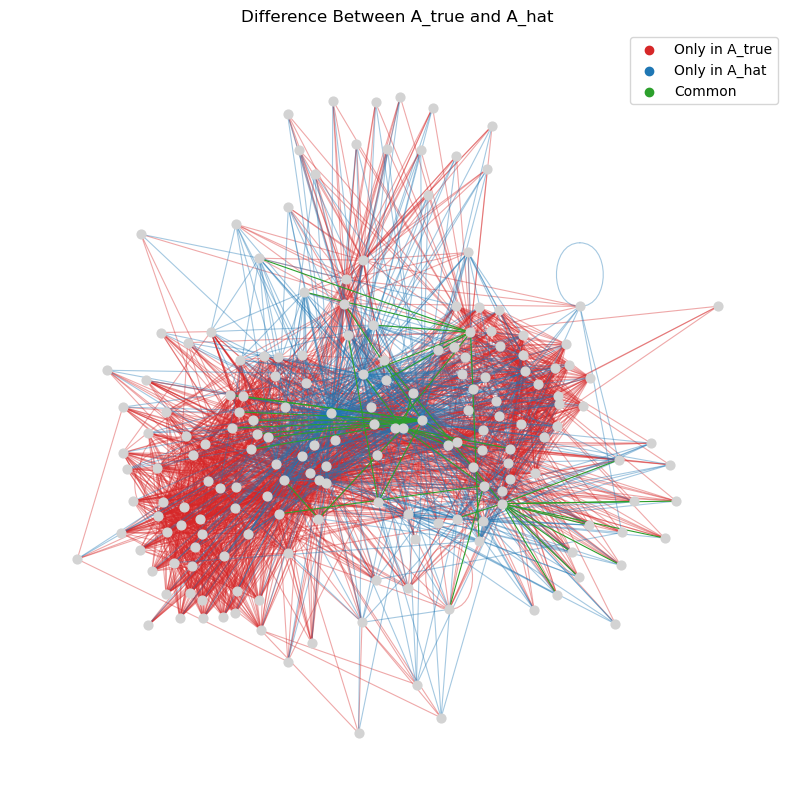

In [133]:
plot_network_diff(A_true, A_hat)

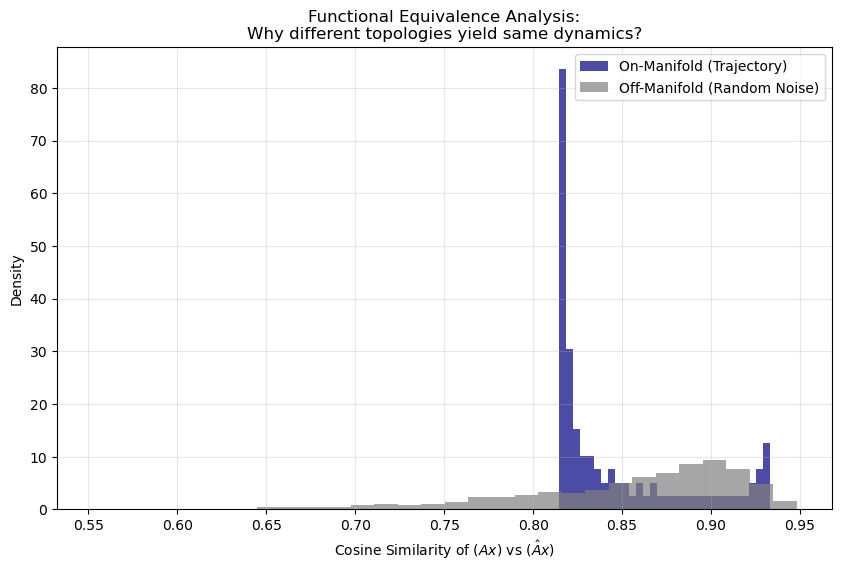

平均相似度 (On-Manifold): 0.8458
平均相似度 (Off-Manifold): 0.8539


In [136]:
def analyze_functional_equivalence(A_true, A_hat, X_obs, num_random=1000):
    """
    分析 A_true 和 A_hat 在 '动力学流形上' 和 '流形外' 的等效性。
    """
    N = A_true.shape[0]
    
    # 1. 在流形上 (On-Manifold): 使用观测到的真实轨迹 X_obs
    # 计算 A * x
    # 注意：X_obs 是 (T, N)，我们需要 (N, T) 来做矩阵乘法 A @ x
    states_manifold = X_obs.T 
    action_true_m = A_true @ states_manifold
    action_hat_m  = A_hat @ states_manifold
    
    # 计算每一时刻的余弦相似度
    # (N, T) -> 对每一列计算相似度
    sim_manifold = []
    for t in range(action_true_m.shape[1]):
        v1 = action_true_m[:, t].reshape(1, -1)
        v2 = action_hat_m[:, t].reshape(1, -1)
        sim = cosine_similarity(v1, v2)[0, 0]
        sim_manifold.append(sim)
        
    # 2. 在流形外 (Off-Manifold): 使用完全随机的状态
    # 模拟随机状态 (例如均匀分布或高斯分布，范围与真实状态一致)
    x_min, x_max = np.min(X_obs), np.max(X_obs)
    states_random = np.random.uniform(x_min, x_max, (N, num_random))
    
    action_true_r = A_true @ states_random
    action_hat_r  = A_hat @ states_random
    
    sim_random = []
    for i in range(num_random):
        v1 = action_true_r[:, i].reshape(1, -1)
        v2 = action_hat_r[:, i].reshape(1, -1)
        sim = cosine_similarity(v1, v2)[0, 0]
        sim_random.append(sim)
        
    # 3. 绘图
    plt.figure(figsize=(10, 6))
    plt.hist(sim_manifold, bins=30, alpha=0.7, label='On-Manifold (Trajectory)', color='navy', density=True)
    plt.hist(sim_random, bins=30, alpha=0.7, label='Off-Manifold (Random Noise)', color='gray', density=True)
    
    plt.xlabel("Cosine Similarity of $(Ax)$ vs $(\hat{A}x)$")
    plt.ylabel("Density")
    plt.title("Functional Equivalence Analysis:\nWhy different topologies yield same dynamics?")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"平均相似度 (On-Manifold): {np.mean(sim_manifold):.4f}")
    print(f"平均相似度 (Off-Manifold): {np.mean(sim_random):.4f}")

# 运行分析
analyze_functional_equivalence(A_true, A_hat, X_obs)

In [140]:
N = A_true.shape[0]
num_random = 1000

# 1. 在流形上 (On-Manifold): 使用观测到的真实轨迹 X_obs
# 计算 A * x
# 注意：X_obs 是 (T, N)，我们需要 (N, T) 来做矩阵乘法 A @ x
states_manifold = X_obs.T 
action_true_m = A_true @ states_manifold
action_hat_m  = A_hat @ states_manifold

# 计算每一时刻的余弦相似度
# (N, T) -> 对每一列计算相似度
sim_manifold = []
for t in range(action_true_m.shape[1]):
    v1 = action_true_m[:, t].reshape(1, -1)
    v2 = action_hat_m[:, t].reshape(1, -1)
    sim = cosine_similarity(v1, v2)[0, 0]
    sim_manifold.append(sim)
    
# 2. 在流形外 (Off-Manifold): 使用完全随机的状态
# 模拟随机状态 (例如均匀分布或高斯分布，范围与真实状态一致)
x_min, x_max = np.min(X_obs), np.max(X_obs)
states_random = np.random.uniform(x_min, x_max, (N, num_random))

action_true_r = A_true @ states_random
action_hat_r  = A_hat @ states_random

sim_random = []
for i in range(num_random):
    v1 = action_true_r[:, i].reshape(1, -1)
    v2 = action_hat_r[:, i].reshape(1, -1)
    sim = cosine_similarity(v1, v2)[0, 0]
    sim_random.append(sim)

<font size = 5 color = black>From the Ranks to more networks</font>

In [38]:
def generate_rdpg_network(A_backbone, k=None, seed=None):
    """
    方法 1: 随机点积图生成 (RDPG)
    保留骨架作为“连接概率”，重新采样生成具体的边。
    
    参数:
    A_backbone: np.array, 骨架矩阵 (通常是 A_hat)
    k: int, 截断秩 (如果 A_backbone 已经是低秩的，可设为 None)
    
    返回:
    A_new: 重新采样生成的网络
    """
    if seed is not None:
        np.random.seed(seed)
        
    # 1. 提取低秩骨架 L (期望矩阵 <W>)
    U, S, Vt = svd(A_backbone, full_matrices=False)
    if k is None:
        k = len(S)
    
    # 重构期望矩阵 P (概率矩阵)
    # 取绝对值或 ReLU 确保非负 (作为概率/强度期望)
    P = np.abs(U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :])
    
    # 归一化概率 (防止数值超过 1，如果是加权网络，这里 P 代表期望权重)
    # 对于加权网络，我们假设 A_new ~ Poisson(P) 或 A_new ~ Normal(P, noise)
    # 这里使用泊松采样来模拟离散的连接事件，保持期望值为 P
    A_new = np.random.poisson(P).astype(float)
    
    # 或者：如果只想生成二值拓扑，再赋予平均权重
    # prob_matrix = np.clip(P, 0, 1)
    # A_binary = np.random.binomial(1, prob_matrix)
    # A_new = A_binary * np.mean(A_backbone[A_backbone>0])
    
    return A_new

In [39]:
def generate_configuration_model(A_origin, swaps=10, seed=None):
    """
    方法 2: 加权构型模型 (保持强度重连)
    保留每个节点的入度/出度强度，但随机打乱连接结构。
    
    参数:
    swaps: int, 每个边平均交换次数 (建议 > 10)
    """
    if seed is not None:
        np.random.seed(seed)
        
    A_new = A_origin.copy()
    N = A_new.shape[0]
    
    # 获取所有非零边的索引
    # rows, cols = np.nonzero(A_new) # 如果是稀疏矩阵
    # 这里假设是稠密矩阵，为了效率，我们进行随机交换操作
    
    # Maslov-Sneppen 算法的加权变体 (保持 Strength)
    # 随机选取两个边 (i, j) 和 (u, v)，交换权重 -> (i, v) 和 (u, j)
    # 注意：对于有向加权图，这保留了 i 的出度和 j 的入度
    
    num_swaps = int(swaps * N * N) # 总交换次数
    
    for _ in range(num_swaps):
        # 随机选四个节点
        i, u = np.random.randint(0, N, 2)
        j, v = np.random.randint(0, N, 2)
        
        # 确保不重合 (简单起见，重合跳过)
        if i == u or j == v:
            continue
            
        # 交换权重: w_ij, w_uv -> w_iv, w_uj
        # 这种交换保持了:
        # i 的出度总和不变 (w_ij + w_iv -> w_iv + w_ij)
        # j 的入度总和不变 (w_ij + w_uj -> w_uj + w_ij)
        
        w1 = A_new[i, j]
        w2 = A_new[u, v]
        
        A_new[i, j] = w2
        A_new[u, v] = w1
        
        # 注意：这实际上是交换了边的“终点”
        
    return A_new

In [40]:
def generate_rotated_subspace(A_backbone, k=None, seed=None):
    """
    方法 3: 子空间随机旋转
    保持奇异值(S)不变，随机旋转奇异向量(U, V)。
    生成具有完全相同代数性质(秩、谱)但拓扑不同的网络。
    """
    if seed is not None:
        np.random.seed(seed)
        
    U, S, Vt = svd(A_backbone, full_matrices=False)
    if k is None:
        k = len(S)
        
    # 1. 生成随机正交矩阵 Q (k x k)
    H = np.random.randn(k, k)
    Q, _ = np.linalg.qr(H) # QR分解得到正交矩阵
    
    # 2. 旋转向量
    # A_new = (U Q) * S * (V Q)^T
    # 这相当于在 latent space 中旋转了坐标轴
    U_rot = U[:, :k] @ Q
    Vt_rot = Q.T @ Vt[:k, :]
    
    # 3. 重构
    A_new = U_rot @ np.diag(S[:k]) @ Vt_rot
    
    # 物理约束：取绝对值以避免旋转产生的负权重 (视具体动力学要求而定)
    return np.abs(A_new)

In [41]:
def generate_noise_perturbed(A_backbone, noise_level=0.1, seed=None):
    """
    方法 4: 噪声注入
    在骨架基础上添加随机噪声矩阵 R。
    W = <W> + R
    """
    if seed is not None:
        np.random.seed(seed)
        
    N = A_backbone.shape[0]
    
    # 生成噪声矩阵 R
    # 假设噪声服从均值为0的高斯分布
    # 噪声强度相对于骨架的平均强度
    avg_strength = np.mean(np.abs(A_backbone))
    sigma = noise_level * avg_strength
    
    R = np.random.normal(0, sigma, (N, N))
    
    # 叠加
    A_new = A_backbone + R
    
    # 物理约束：通常不允许负权重 (例如传播率不能为负)
    A_new = np.maximum(A_new, 0)
    
    return A_new

In [96]:
def generate_isospectral_random_network(A_backbone, seed=None):
    """
    生成等谱随机网络：
    保留 A_backbone 的奇异值谱 (代数骨架)，但完全随机化其奇异向量 (几何结构)。
    
    这用于测试：如果两个网络具有完全相同的“复杂度”和“能量”，
    但连接结构毫无关系，动力学是否相似？
    """
    if seed is not None:
        np.random.seed(seed)
    
    N = A_backbone.shape[0]
    
    # 1. 提取代数骨架 (S)
    # 不需要计算 U, Vt，只取 S
    S = svd(A_backbone, compute_uv=False)
    
    # 2. 生成完全随机的几何结构 (Random U, Random V)
    # 使用 QR 分解生成均匀分布的随机正交矩阵 (Haar measure)
    H1 = np.random.randn(N, N)
    Q_U, _ = qr(H1)
    
    H2 = np.random.randn(N, N)
    Q_V, _ = qr(H2)
    
    # 3. 组装网络
    # A_new 拥有和 A_backbone 完全相同的奇异值谱
    A_iso = Q_U @ np.diag(S) @ Q_V.T
    
    # 4. 物理约束处理
    # 随机旋转必然产生负值。对于生物/物理网络，通常取绝对值保留强度。
    # 注意：取绝对值会轻微改变谱，但这是保持物理意义的最小代价。
    return np.abs(A_iso)

In [51]:
k_eff = 7

A_rdpg = generate_rdpg_network(A_hat, k=k_eff, seed=42)
# A_config = generate_configuration_model(A_true, swaps=20, seed=42) # Based on A_true degree
A_rot = generate_rotated_subspace(A_hat, k=k_eff, seed=42)
# A_noise = generate_noise_perturbed(A_hat, noise_level=0.2, seed=42)

In [99]:
A_isospec = generate_isospectral_random_network(A_hat, seed=42)

In [101]:
auc = calculate_topology_auc(A_true, A_rdpg)
print(f"AUC A_rdpg: {auc:.4f}")
auc = calculate_topology_auc(A_true, A_rot)
print(f"AUC A_rot: {auc:.4f}")
auc = calculate_topology_auc(A_true, A_isospec)
print(f"AUC A_isospec: {auc:.4f}")

AUC A_rdpg: 0.5008
AUC A_rot: 0.4499
AUC A_isospec: 0.5078


In [61]:
print("Predicting future dynamics on A_rdpg...")
T_pred_steps = T_total_steps - T_train_steps
X_future_pred_rdpg = model.simulate(A_rdpg, T_steps=T_pred_steps, init_state=x0_pred)
X_full_pred_rdpg = np.vstack([X_train, X_future_pred_rdpg])
print("A_rdpg simulation finish")

print("Predicting future dynamics on A_rot...")
T_pred_steps = T_total_steps - T_train_steps
X_future_pred_rot = model.simulate(A_rot, T_steps=T_pred_steps, init_state=x0_pred)
X_full_pred_rot = np.vstack([X_train, X_future_pred_rot])
print("A_rot simulation finish")

Predicting future dynamics on A_rdpg...
A_rdpg simulation finish
Predicting future dynamics on A_rot...
A_rot simulation finish


In [102]:
print("Predicting future dynamics on A_isospec...")
T_pred_steps = T_total_steps - T_train_steps
X_future_pred_isospec = model.simulate(A_isospec, T_steps=T_pred_steps, init_state=x0_pred)
X_full_pred_isospec = np.vstack([X_train, X_future_pred_isospec])
print("A_isospec simulation finish")

Predicting future dynamics on A_isospec...
A_isospec simulation finish


In [75]:
def plot_custom_dynamics_v2(X_true, simulations_dict, T_train_steps, dt=0.1, 
                            scatter_interval=3, 
                            num_plot_nodes=10, 
                            specific_nodes=None,
                            color_by_node=True,  # <--- 新增控件
                            title=None):
    """
    支持 '节点着色' 和 '网络着色' 切换的定制化绘图函数。
    """
    
    N = X_true.shape[1]
    time_steps = np.arange(len(X_true)) * dt
    
    # 1. 确定节点索引
    if specific_nodes is not None:
        nodes_to_plot = np.array(specific_nodes)
    else:
        if num_plot_nodes > N: num_plot_nodes = N
        nodes_to_plot = np.linspace(0, N-1, num_plot_nodes, dtype=int)
    
    n_sample = len(nodes_to_plot)
    fig, ax = plt.subplots(figsize=(14, 8))

    # ========================================================
    # A. 颜色策略生成
    # ========================================================
    # 1. 节点颜色池 (用于 color_by_node=True)
    if n_sample <= 10:
        node_cmap = [plt.cm.tab10(i) for i in range(n_sample)]
    else:
        node_cmap = plt.cm.jet(np.linspace(0, 1, n_sample))
        
    # 2. 网络颜色池 (用于 color_by_node=False)
    # True 为灰色，其他网络使用 Set1 或 Tab10
    net_colors = [plt.cm.Set1(i) for i in range(len(simulations_dict))]

    # ========================================================
    # B. 绘制 Ground Truth (实线)
    # ========================================================
    for i, node_idx in enumerate(nodes_to_plot):
        if color_by_node:
            c = node_cmap[i]
            alpha = 0.6
            lw = 2
        else:
            c = 'gray' # 宏观模式下，真值作为背景
            alpha = 0.4
            lw = 1.5
            
        ax.plot(time_steps, X_true[:, node_idx], 
                color=c, linestyle='-', linewidth=lw, alpha=alpha)

    # ========================================================
    # C. 绘制 模拟结果 (散点)
    # ========================================================
    markers = ['o', 'x', '^', 's', 'D', '*']
    
    for net_idx, (label_name, X_sim) in enumerate(simulations_dict.items()):
        if X_sim is None: continue
        
        marker = markers[net_idx % len(markers)]
        
        # 稀疏采样
        sparse_indices = np.arange(0, len(X_sim), scatter_interval)
        t_sparse = time_steps[sparse_indices]
        
        for i, node_idx in enumerate(nodes_to_plot):
            # 1. 确定颜色
            if color_by_node:
                c = node_cmap[i]
            else:
                c = net_colors[net_idx]
            
            # 2. 确定样式 (保留空心圆美学)
            if marker == 'o':
                # 空心圆：边缘带色，内部透明
                ax.scatter(t_sparse, X_sim[sparse_indices, node_idx], 
                           edgecolors=c, facecolors='none', marker='o', 
                           s=45, linewidth=1.5, alpha=0.9)
            else:
                # 其他形状：实心
                ax.scatter(t_sparse, X_sim[sparse_indices, node_idx], 
                           color=c, marker=marker, s=45, alpha=0.8)

    # ========================================================
    # D. 智能图例 (Custom Legend)
    # ========================================================
    legend_elements = []
    
    if color_by_node:
        # --- 模式1: 颜色=节点，形状=网络 ---
        # True
        legend_elements.append(Line2D([0], [0], color='black', lw=2, label='Ground Truth (Line)'))
        
        # Simulates (用黑色形状代表网络类型)
        for net_idx, (label_name, _) in enumerate(simulations_dict.items()):
            m = markers[net_idx % len(markers)]
            if m == 'o':
                legend_elements.append(Line2D([0], [0], marker='o', color='w', label=label_name,
                                              markerfacecolor='none', markeredgecolor='black', mew=1.5))
            else:
                legend_elements.append(Line2D([0], [0], marker=m, color='w', label=label_name,
                                              markerfacecolor='black', markersize=8))
    else:
        # --- 模式2: 颜色=网络，形状=网络 ---
        # True
        legend_elements.append(Line2D([0], [0], color='gray', lw=2, label='Ground Truth'))
        
        # Simulates (用彩色形状代表网络)
        for net_idx, (label_name, _) in enumerate(simulations_dict.items()):
            m = markers[net_idx % len(markers)]
            c = net_colors[net_idx]
            if m == 'o':
                legend_elements.append(Line2D([0], [0], marker='o', color='w', label=label_name,
                                              markerfacecolor='none', markeredgecolor=c, mew=1.5))
            else:
                legend_elements.append(Line2D([0], [0], marker=m, color='w', label=label_name,
                                              markerfacecolor=c, markersize=8))

    # ========================================================
    # E. 装饰
    # ========================================================
    if T_train_steps > 0:
        ax.axvline(x=T_train_steps * dt, color='k', linestyle=':', linewidth=2, alpha=0.6)

    title_suffix = "Individual Node Tracking" if color_by_node else "Network Model Envelope"
    final_title = title if title else f"Dynamics Comparison: {title_suffix}"
    
    ax.set_title(final_title, fontsize=16)
    ax.set_xlabel("Time Steps", fontsize=12)
    ax.set_ylabel("State $x_i(t)$", fontsize=12)
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [110]:
sim_data = {}
sim_data = {
    # 'Surrogate (A_hat)': X_full_pred,          # 红色圆点 (自动)
    # 'RDPG Re-sampled':   X_full_pred_rdpg,     # 橙色叉号 (自动)
    # 'Rotated Subspace':  X_full_pred_rot,       # 绿色三角 (自动)
    'Isospectral Random':  X_full_pred_isospec
    # 你甚至可以加更多，比如 'Noise Perturbed': X_noise ...
}

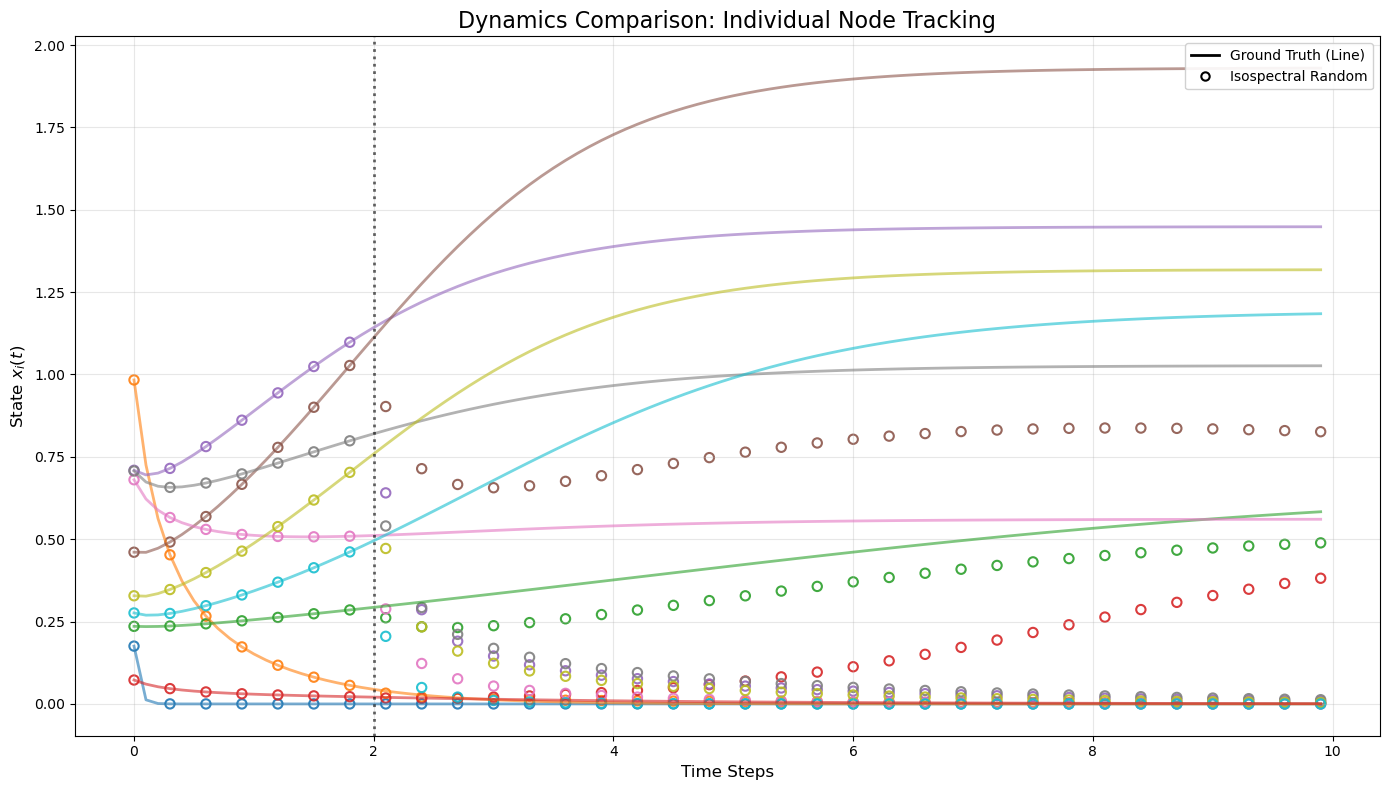

In [111]:
plot_custom_dynamics_v2(
    X_true=X_obs, 
    simulations_dict=sim_data, 
    T_train_steps=T_train_steps,
    specific_nodes=range(10),  # 您指定的节点
    color_by_node=True,
    # title="Micro View: Specific Node Tracking (Color=NodeID)"
)

In [95]:
epsilon_t, epsilon_bar = evaluate_prediction_accuracy(X_obs, X_full_pred, T_train_steps)
epsilon_bar

np.float64(0.01926509652049879)

In [93]:
epsilon_t, epsilon_bar = evaluate_prediction_accuracy(X_obs, X_full_pred_rdpg, T_train_steps)
epsilon_bar

np.float64(0.10508412058435711)

In [94]:
epsilon_t, epsilon_bar = evaluate_prediction_accuracy(X_obs, X_full_pred_rot, T_train_steps)
epsilon_bar

np.float64(0.15833588543954852)

In [109]:
epsilon_t, epsilon_bar = evaluate_prediction_accuracy(X_obs, X_full_pred_isospec, T_train_steps)
epsilon_bar

np.float64(0.27635098064238467)

In [115]:
all_metrics = []
all_metrics.append(get_comprehensive_metrics(A_true))

A_variants = [A_rdpg, A_rot, A_noise, A_isospec]
names = ["rdpg (k_eff=7)", "rotated_subspace (k_eff=7)", "isospec"]
for A_v, name in zip(A_variants, names):
    m = get_comprehensive_metrics(A_v, name=name)
    all_metrics.append(m)

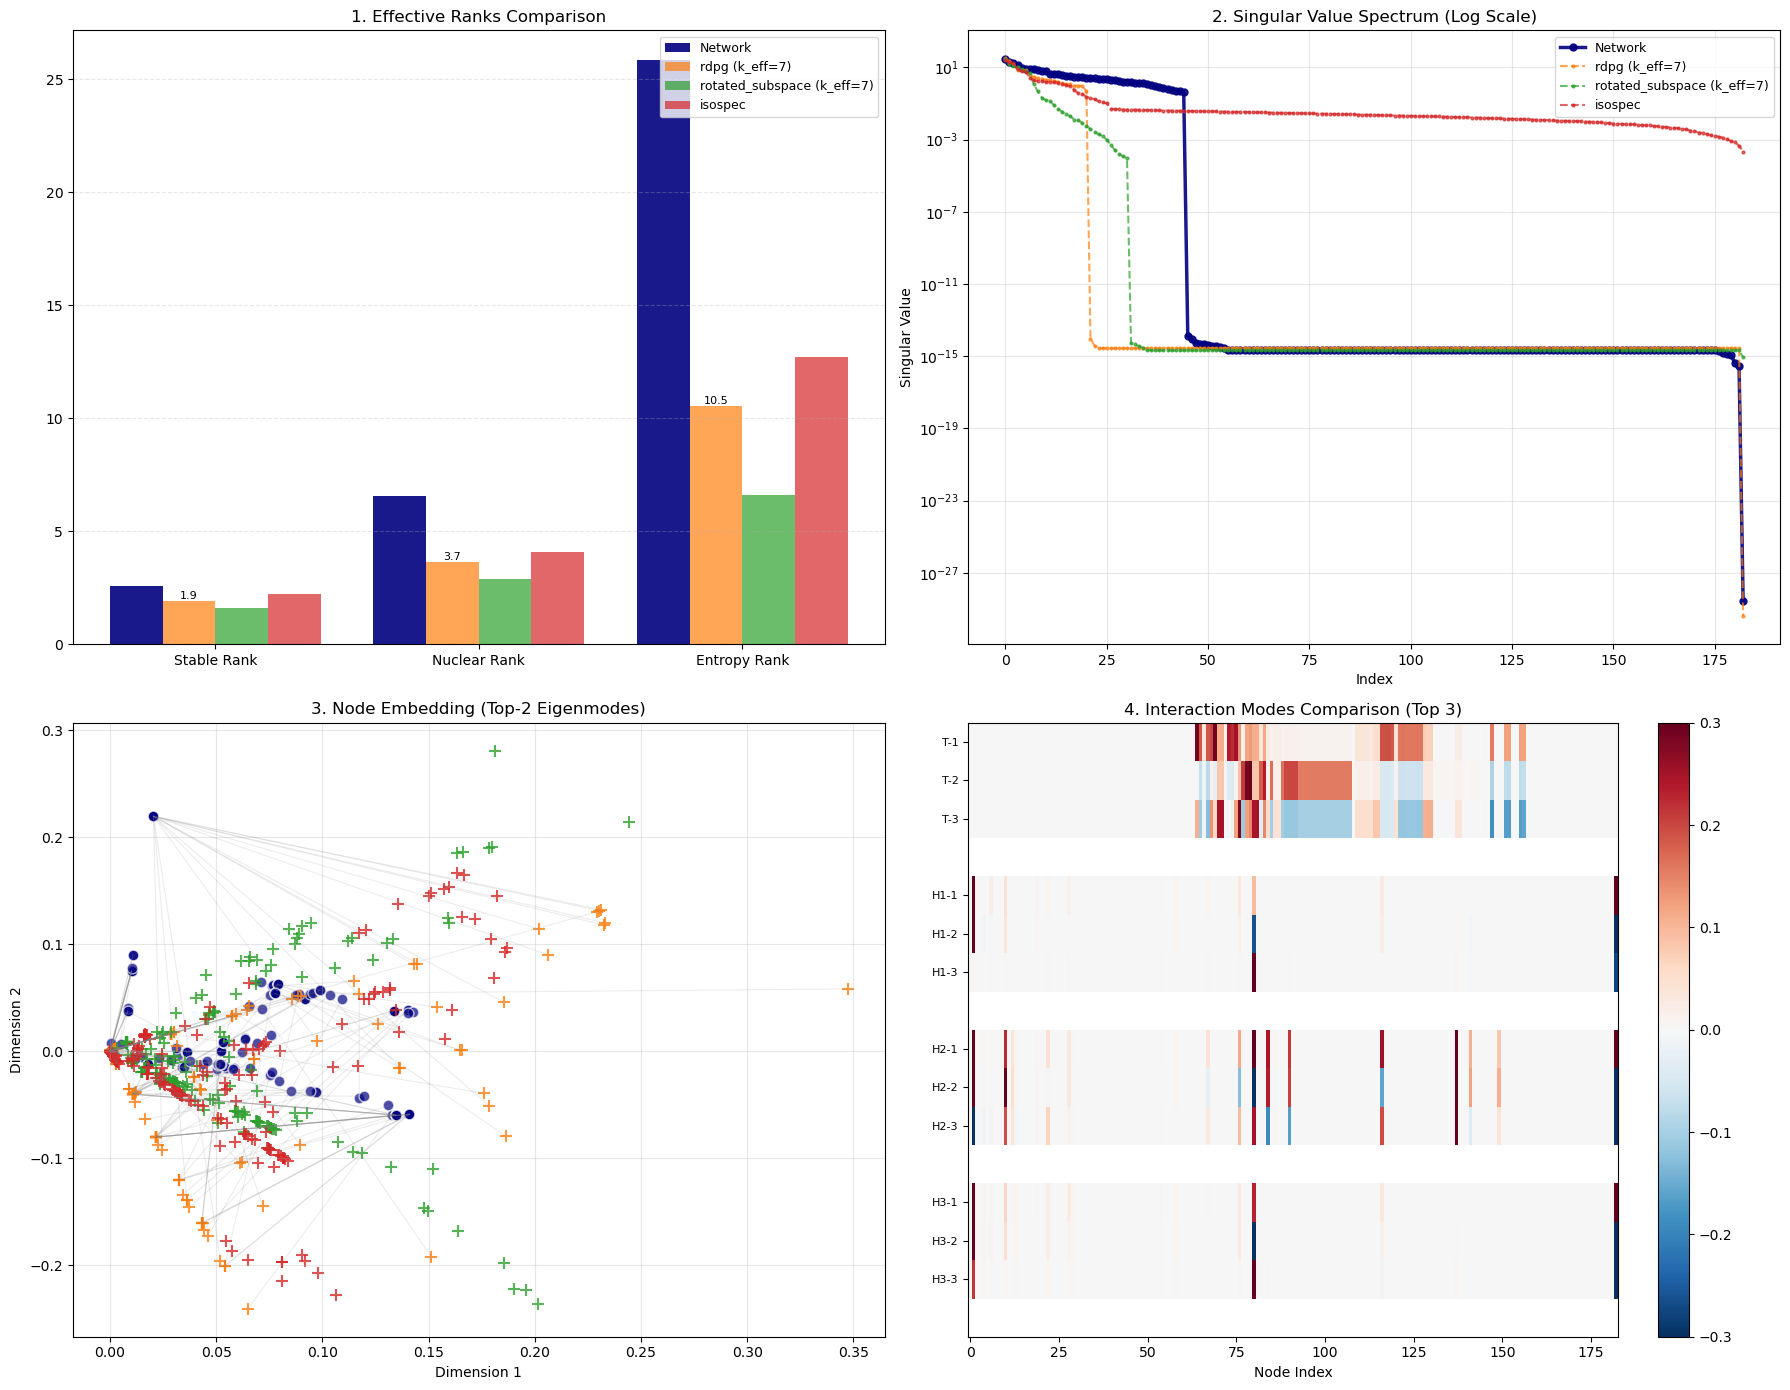

In [116]:
plot_multi_matrix_comparison(all_metrics)

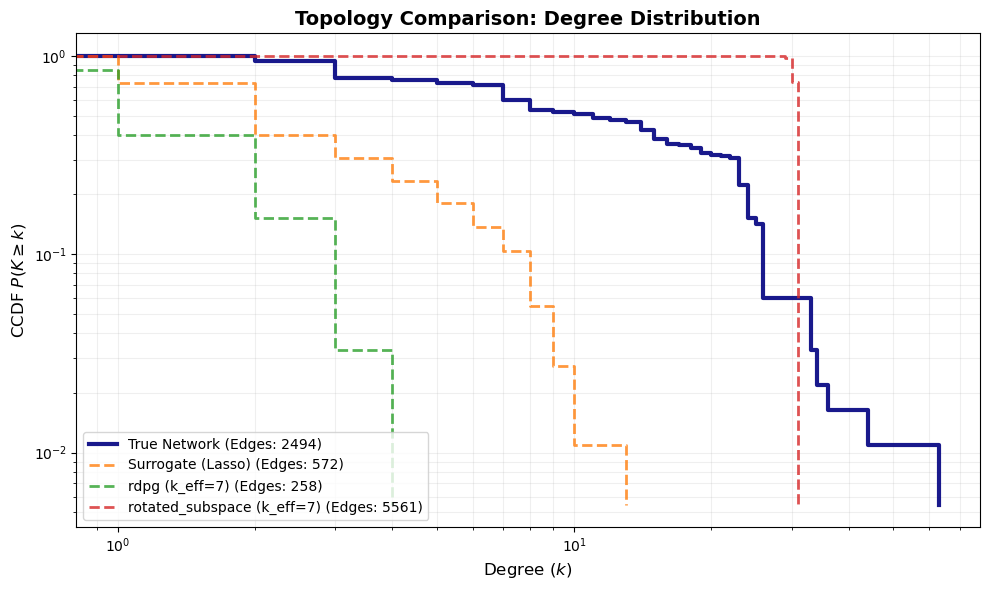

In [88]:
plot_topology_comparison(all_metrics, figsize=(10, 6))